<a href="https://colab.research.google.com/github/kwyvanessa/Datathon_2022/blob/main/WID_Datathon_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datathon 2022

## Problem Statement

Which of the component indicators that are part of the UN composite indices (HDI, GDI, and GII) have the strongest correlation with the gender pay gap.  

# Import Data

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import sklearn

from pandas.plotting import scatter_matrix
from google.colab import drive

## UN Human Development Reports data

[Data Dictionary](https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Composite_indices_metadata.xlsx) <br>

This dataset from the [UNHDR](https://hdr.undp.org/data-center) includes time series data for several UN HDC indices and supporting measurements in a single tabular file. The full original dataset can be downloaded from UNHDR [here](https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Composite_indices_complete_time_series.csv).   <br>

The original datset includes annual data in columnar format.  We used Tableau Prep to quickly transform the annual data into a row format, with one row for each Country/Year combination, and a single column for each variable.

Data Dictionary <br>
country: Country that data relates to <br>
year: Year of measurment <br>
region: Developing region: (AS: Arab States (20); EAP: East Asia and Pacific (26); ECA: Europe and Central Asia (17); LAC: Latin America and Caribbean (33); SA: South Asia (9); SSA: Sub Saharan Africa) <br>

Composite Indices: <br>
hdi: Human Development Index<br>
gdi:  Gender Development Index<br>
gii: Gender inequality index<br>
ihdi: Inequality-adjusted HDI<br>

Raw indicators included in composite indices:<br>
le: life expectancy<br>
gnipc: Gross National Income per capita<br>
mys: Mean years of schooling<br>
eys: Expected Years of Schooling<br>
mmr: Material mortality rate<br>
abr: Adolescent birth rate <br>
se: population with atleast some secondary ed<br>
pr: share of seats in parliament<br>
lfpr: labor force participation rate<br>
co2_prod: Co2 emissions per capita<br>
coef_inc: Coefficient of inequality<br>
ineq_le: Inequality in life expectancy<br>
ineq_inc: Inequality in income


In [2]:
# Use curl to retrieve transformed csv file from github repo and save in Colab working director
!curl -O "https://raw.githubusercontent.com/kwyvanessa/Datathon_2022/main/hdrDF_by_year_data.csv"

# Read in the csv from the Colab working directory - using a subset of the columns, and parse_dates are enabled to format of the datetime strings. I
hdrDF_y = pd.read_csv("/content/hdrDF_by_year_data.csv",\
                      usecols = ['iso3','country','region', 'hdicode','Year','hdi','le','mys', 'eys','gnipc','gdi','ihdi','coef ineq','ineq le', 'ineq inc', 'gii','mmr','abr','pr f','lfpr f', 'lfpr m', 'se f', 'se m'],\
                      infer_datetime_format= True)
# Rename columns for consistency of style
hdrDF_y.rename({'coef ineq':'coef_ineq','se m':'se_m','se f':'se_f','pr f':'pr_f','ineq le':'ineq_le','ineq inc':'ineq_inc', 'Year':'date', 'lfpr m': 'lfpr_m', 'lfpr f': 'lfpr_f'}, axis =1, inplace = True)

hdrDF_y['date'] = pd.to_datetime(hdrDF_y['date'], infer_datetime_format = True ) # convert the date column to datetime format 
hdrDF_y['year'] = hdrDF_y['date'].dt.year # create a new column for the year of the observation
hdrDF_y.sample(10)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2023k  100 2023k    0     0  5684k      0 --:--:-- --:--:-- --:--:-- 5684k


,iso3,hdicode,region,date,country,hdi,coef_ineq,se_m,se_f,pr_f,...,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year
4264,ZZA.VHHD,NaN,NaN,2021-01-01,Very high human development,0.896,9.929676,89.410560,86.973450,29.134503,...,78.521301,4.675609,18.799121,0.805,43751.596460,0.155,0.986,16.506485,14.092082,2021
4878,AFG,Low,SA,2019-01-01,Afghanistan,0.488,NaN,14.738381,5.159222,27.243590,...,63.564500,27.021290,NaN,NaN,2097.889450,0.665,0.712,10.263844,86.803000,2019
4692,ZZE.AS,NaN,NaN,1994-01-01,Arab States,0.582,NaN,35.624378,23.981969,3.607420,...,65.562309,NaN,NaN,NaN,10033.865050,0.682,0.782,9.131453,64.639002,1994
2356,ZZG.ECA,NaN,NaN,1994-01-01,Europe and Central Asia,0.647,NaN,64.691217,56.504393,5.222672,...,67.136734,NaN,NaN,NaN,8346.075282,0.481,0.934,10.747861,57.234540,1994
5123,ZZI.SA,NaN,NaN,2002-01-01,South Asia,0.511,NaN,40.011464,22.589869,5.994090,...,64.065313,NaN,NaN,NaN,3059.720226,0.674,0.763,8.295481,91.910413,2002
717,PLW,High,EAP,2016-01-01,Palau,0.778,NaN,97.331322,96.889137,13.793103,...,63.852100,14.413215,NaN,NaN,19783.907680,NaN,NaN,16.244772,38.158000,2016
4113,JPN,Very High,NaN,2001-01-01,Japan,0.880,NaN,79.984000,78.112000,10.655738,...,81.509000,NaN,NaN,NaN,38484.138760,0.149,0.959,14.262032,5.744000,2001
610,TON,High,EAP,2001-01-01,Tonga,0.688,NaN,73.361526,70.394897,0.000000,...,69.127000,NaN,NaN,NaN,5612.256069,0.663,0.956,13.405990,22.748000,2001
6154,LIE,Very High,NaN,2016-01-01,Liechtenstein,0.923,NaN,NaN,NaN,20.000000,...,82.393200,5.517645,NaN,NaN,126592.349700,NaN,NaN,14.720930,3.587000,2016
2759,PLW,High,EAP,2003-01-01,Palau,0.754,NaN,NaN,NaN,0.000000,...,67.227500,NaN,NaN,NaN,14168.381550,NaN,NaN,14.660549,31.006000,2003


In [3]:
# Drop rows that have an iso value that begins with 'ZZ'
hdrDF_y.drop(labels = hdrDF_y.loc[hdrDF_y['iso3'].str.contains('ZZ') == True], axis = 0, errors='ignore', inplace = True)       
hdrDF_y

,iso3,hdicode,region,date,country,hdi,coef_ineq,se_m,se_f,pr_f,...,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year
0,DJI,Low,AS,2009-01-01,Djibouti,0.445,NaN,NaN,NaN,13.846154,...,59.6727,NaN,NaN,NaN,2803.308019,NaN,NaN,5.583350,24.647,2009
1,BLZ,Medium,LAC,2001-01-01,Belize,0.643,NaN,54.882461,54.105932,13.513514,...,68.3572,NaN,NaN,NaN,6175.395903,0.509,0.924,11.864430,99.264,2001
2,SVN,Very High,NaN,2015-01-01,Slovenia,0.903,5.297673,98.930481,97.439178,27.692308,...,80.8218,2.487548,11.17606,0.854,32738.328430,0.063,1.003,17.291990,4.679,2015
3,MLT,Very High,NaN,2005-01-01,Malta,0.832,NaN,67.836281,58.782822,9.230769,...,79.6465,NaN,NaN,NaN,28205.895980,0.285,0.923,14.814800,20.183,2005
4,ROU,Very High,NaN,1994-01-01,Romania,0.682,NaN,78.510602,65.954482,5.555556,...,69.5789,NaN,NaN,NaN,11361.396570,0.482,0.957,10.283660,46.290,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,PAK,Low,SA,2006-01-01,Pakistan,0.493,NaN,44.042240,19.914881,20.361991,...,63.7312,NaN,NaN,NaN,3761.372437,0.614,0.694,6.281110,60.166,2006
6588,COL,High,LAC,1991-01-01,Colombia,0.619,NaN,42.369342,42.013230,9.811321,...,68.8127,NaN,NaN,NaN,7978.104071,0.531,0.955,9.490810,96.557,1991
6589,GRD,High,LAC,1997-01-01,Grenada,NaN,NaN,NaN,NaN,NaN,...,72.5677,NaN,NaN,NaN,8826.030278,NaN,NaN,15.529503,63.858,1997
6590,FRA,Very High,NaN,1994-01-01,France,0.823,NaN,59.911082,51.941091,9.020045,...,77.7678,NaN,NaN,NaN,34801.772780,0.202,0.982,15.589100,10.020,1994


## UN Women Data Hub Wage Data

Data on Average Hourly Wage by gender, country and year was sourced from the [UN Women SDG Indicators Dashboard](https://data.unwomen.org/data-portal).<br>
The Average Hourly Wage data is averaged for all occupations.<br>
This dataset will be used to calculate a 'Wage Ratio' to estimate the target variable of the gender pay gap.  The Wage Ratio is calculated below as the Average Hourly Wage (Female) divided by the Average Hourly Wage (Male). 

In [4]:
# Use curl to get csv file from github repo and save in Colab working directory
!curl -O "https://raw.githubusercontent.com/kwyvanessa/Datathon_2022/main/UNWDH_wages_all.csv"
# Read in the csv from the working directory  - using a subset of the columns.
wages = pd.read_csv("/content/UNWDH_wages_all.csv", usecols = ['REF_AREA Description','TIME_PERIOD','OBS_VALUE','Sex'])
#rename columns
wages.rename({'REF_AREA Description': 'Country', 'TIME_PERIOD': 'Year', 'OBS_VALUE': 'avgHrlyWage'},axis=1, inplace = True) 
#Filter the data
wages = wages.loc[wages['Sex'].isin(['Female','Male'])]
wages.sample(10)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  629k  100  629k    0     0  2265k      0 --:--:-- --:--:-- --:--:-- 2265k


,Country,Year,avgHrlyWage,Sex
726,Argentina,2003,4.6,Female
596,Paraguay,2001,5409.1,Male
783,Austria,2010,16.4,Male
416,Venezuela (Bolivarian Republic of),2004,2440.0,Female
546,Nicaragua,2005,15.1,Male
834,Bolivia (Plurinational State of),2006,7.2,Female
716,Argentina,2000,4.0,Female
561,Norway,2018,306.0,Male
363,Uruguay,2006,58.9,Male
313,Portugal,2018,5.0,Female


In [5]:
#Pivot the data
wages_wide_mi = wages.pivot(index = ['Country', 'Year'], columns = 'Sex', values = ['avgHrlyWage'])
#drop the multilevel column index
wages_wide_mi.columns = wages_wide_mi.columns.droplevel(0)
#remove the multilevel index
wages_wide = wages_wide_mi.reset_index()
wages_wide.sample(10)

Sex,Country,Year,Female,Male
231,Honduras,2015,41.8,32.7
107,Costa Rica,2005,1084.0,1147.0
64,Brazil,2001,3.3,4.0
208,Guatemala,2010,13.2,11.5
285,Malta,2018,11.0,13.0
276,Malaysia,2014,11.4,11.2
206,Guatemala,2004,8.7,9.6
355,Peru,2007,4.1,4.9
302,Mongolia,2019,3800.2,4206.2
356,Peru,2008,4.3,5.4


In [6]:
# Add a new calculated field for the ratio of Female wages in a given year and country as a percentage of Male wages
wages_wide['wage_ratio'] = wages_wide['Female'] / wages_wide['Male']
wages_wide.sample(10)

Sex,Country,Year,Female,Male,wage_ratio
347,Paraguay,2019,14720.5,13745.0,1.070971
392,Samoa,2012,7.9,8.6,0.918605
111,Costa Rica,2012,2520.8,2353.2,1.071222
249,Israel,2015,50.6,59.6,0.848993
378,Republic of Korea,2011,11931.0,17962.0,0.664236
291,Mauritius,2016,106.1,131.6,0.806231
152,Ecuador,2007,1.7,2.0,0.850000
258,Jordan,2018,2.0,1.8,1.111111
480,Viet Nam,2018,27110.0,29829.5,0.908832
120,Curaçao,2018,69.6,75.6,0.920635


In [7]:
# Drop unneeded columns, rename columns
wages_wide.drop(['Female','Male'], axis =1, inplace = True, errors = 'ignore')
wages_wide.rename({'Country':'country','Year':'year'}, axis = 1, inplace = True)
wages_wide.sample(10)

Sex,country,year,wage_ratio
138,Dominican Republic,2010,0.983007
477,Viet Nam,2015,0.956549
72,Brazil,2009,0.857143
400,Slovakia,2010,0.807692
244,Indonesia,2019,0.867276
261,Latvia,2010,0.853659
406,Slovenia,2018,0.900000
263,Latvia,2018,0.857143
296,Mexico,2002,0.875000
84,Bulgaria,2014,0.857143


In [8]:
wages_wide.nlargest(10,'wage_ratio')

Sex,country,year,wage_ratio
264,Lebanon,2019,1.409669
393,Samoa,2017,1.302632
213,Guatemala,2015,1.284615
234,Honduras,2018,1.280597
231,Honduras,2015,1.278287
235,Honduras,2019,1.269972
232,Honduras,2016,1.257971
233,Honduras,2017,1.241791
215,Guatemala,2017,1.237037
222,Honduras,2005,1.231760


## Merge Dataframes
Combine the UNHDR data with the UN Wage Data to produce a single dataframe for analysis<br>

In [9]:
# Compare country column from each dataframe
print(f"wages: {wages_wide['country'].nunique()}")
print(f"hdrDF {hdrDF_y['country'].nunique()}")

wages: 102
hdrDF 206


In [10]:
# Rename country values to make consistent between the two datasets
wages_wide.loc[wages_wide['country'] == 'Republic of Korea','country'] = 'Korea (Republic of)' # Korea
wages_wide.loc[wages_wide['country'] == 'United Kingdom of Great Britain and Northern Ireland', 'country'] = 'United Kingdom' # United Kingdom
hdrDF_y.loc[hdrDF_y['country'] == 'Eswatini (Kingdom of)', 'country'] = 'Eswatini' #Eswatini

In [11]:
wages_wide.loc[wages_wide['country'] == 'United Kingdom']

Sex,country,year,wage_ratio
439,United Kingdom,2014,0.792899
440,United Kingdom,2015,0.795181
441,United Kingdom,2016,0.801170
442,United Kingdom,2017,0.801136
443,United Kingdom,2018,0.802198
444,United Kingdom,2019,0.808511


In [12]:
# Merge datasets
paygap = pd.merge(hdrDF_y, wages_wide, how = 'inner', on = ['country','year'])
paygap.sample(10)

,iso3,hdicode,region,date,country,hdi,coef_ineq,se_m,se_f,pr_f,...,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
175,PAN,Very High,LAC,2011-01-01,Panama,0.779,21.639858,61.028280,63.698461,8.450704,...,12.828291,38.307814,0.603,22130.705210,0.507,0.992,12.656850,93.352,2011,1.028571
227,PRT,Very High,NaN,2008-01-01,Portugal,0.822,NaN,38.179062,36.988400,28.260870,...,NaN,NaN,NaN,30147.686030,0.134,0.984,15.959970,15.930,2008,0.875000
301,NLD,Very High,NaN,2018-01-01,Netherlands,0.939,6.843680,91.772148,89.016960,35.555556,...,3.373561,11.790380,0.874,56614.384130,0.027,0.952,18.559931,2.611,2018,0.850000
384,PER,High,LAC,2000-01-01,Peru,0.676,NaN,61.543628,52.239257,10.833333,...,NaN,NaN,NaN,6297.773346,0.518,NaN,12.877790,74.182,2000,0.743590
347,LVA,Very High,NaN,2014-01-01,Latvia,0.846,9.727914,99.285713,99.537773,18.000000,...,4.948761,20.389320,0.761,24833.953800,0.235,1.026,15.817000,18.532,2014,0.816327
183,ECU,High,LAC,2015-01-01,Ecuador,0.765,18.468352,52.246910,52.121620,41.605839,...,10.277110,31.322467,0.619,11685.757290,0.388,0.960,15.198450,79.692,2015,1.071429
245,ECU,High,LAC,2009-01-01,Ecuador,0.731,NaN,43.367401,42.736931,32.258065,...,NaN,NaN,NaN,9944.187625,0.433,NaN,14.544550,92.019,2009,0.900000
423,CRI,Very High,LAC,2019-01-01,Costa Rica,0.819,16.898807,53.994036,55.883270,45.614035,...,5.706110,33.413540,0.673,19684.856810,0.269,0.988,16.545771,44.882,2019,1.077984
252,HTI,Low,LAC,2001-01-01,Haiti,0.472,NaN,27.794000,17.256000,9.090909,...,NaN,NaN,NaN,2879.051184,0.597,NaN,7.988891,72.865,2001,0.839623
344,HND,Medium,LAC,2004-01-01,Honduras,0.572,NaN,17.927257,19.782770,5.468750,...,NaN,NaN,NaN,4164.535959,0.549,0.933,9.732854,108.406,2004,0.990868


# Exploratory Data Analysis

## Shapes, Sizes, and Info

In [13]:
# convert indices from object type to float64
paygap[['hdi','coef_ineq','se_m','se_f','pr_f','mys','eys','mmr','lfpr_m','lfpr_f','le','ineq_le','ineq_inc','ihdi','gnipc','gii','gdi','abr','wage_ratio']] \
  = paygap[['hdi','coef_ineq','se_m','se_f','pr_f','mys','eys','mmr','lfpr_m','lfpr_f','le','ineq_le','ineq_inc','ihdi','gnipc','gii','gdi','abr','wage_ratio']].astype(np.float64)

# Convert date to datetime format
paygap['date'] = pd.to_datetime(paygap['date'], infer_datetime_format = True )

In [14]:
# rows and columns of dataframe
paygap_sh = paygap.shape    # number of instances (rows) and features (cols)
paygap_sz = paygap.size     # the number of elements
paygap_col = paygap.columns # to know just the names of the columns or features

print(f"paygap dataframe: \n\n\
 shape (rows|cols): {paygap_sh}\n \
size: {paygap_sz}\n\n \
Features|Columns\n{paygap_col}")

paygap dataframe: 

 shape (rows|cols): (484, 25)
 size: 12100

 Features|Columns
Index(['iso3', 'hdicode', 'region', 'date', 'country', 'hdi', 'coef_ineq',
       'se_m', 'se_f', 'pr_f', 'mys', 'mmr', 'lfpr_m', 'lfpr_f', 'le',
       'ineq_le', 'ineq_inc', 'ihdi', 'gnipc', 'gii', 'gdi', 'eys', 'abr',
       'year', 'wage_ratio'],
      dtype='object')


In [15]:
# Displays the concise summary of dataframe
paygap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 483
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   iso3        484 non-null    object        
 1   hdicode     484 non-null    object        
 2   region      355 non-null    object        
 3   date        484 non-null    datetime64[ns]
 4   country     484 non-null    object        
 5   hdi         484 non-null    float64       
 6   coef_ineq   320 non-null    float64       
 7   se_m        484 non-null    float64       
 8   se_f        484 non-null    float64       
 9   pr_f        483 non-null    float64       
 10  mys         484 non-null    float64       
 11  mmr         484 non-null    float64       
 12  lfpr_m      484 non-null    float64       
 13  lfpr_f      484 non-null    float64       
 14  le          484 non-null    float64       
 15  ineq_le     353 non-null    float64       
 16  ineq_inc    329 non-null  

## Total count of null values for all the attributes

In [16]:
print("Columns with missing values: ")
print(paygap.columns[paygap.isnull().any()].tolist())

Columns with missing values: 
['region', 'coef_ineq', 'pr_f', 'ineq_le', 'ineq_inc', 'ihdi', 'gii', 'gdi']


In [17]:
# to know just the missing values
print(paygap.isnull().sum())

iso3            0
hdicode         0
region        129
date            0
country         0
hdi             0
coef_ineq     164
se_m            0
se_f            0
pr_f            1
mys             0
mmr             0
lfpr_m          0
lfpr_f          0
le              0
ineq_le       131
ineq_inc      155
ihdi          164
gnipc           0
gii             1
gdi            11
eys             0
abr             0
year            0
wage_ratio      0
dtype: int64


In [18]:
print(paygap.columns[paygap.notnull().any()].tolist())

['iso3', 'hdicode', 'region', 'date', 'country', 'hdi', 'coef_ineq', 'se_m', 'se_f', 'pr_f', 'mys', 'mmr', 'lfpr_m', 'lfpr_f', 'le', 'ineq_le', 'ineq_inc', 'ihdi', 'gnipc', 'gii', 'gdi', 'eys', 'abr', 'year', 'wage_ratio']


In [19]:
# to know just the non null values
total_nn = paygap.count() - paygap.isnull().sum()
print(total_nn)

iso3          484
hdicode       484
region        226
date          484
country       484
hdi           484
coef_ineq     156
se_m          484
se_f          484
pr_f          482
mys           484
mmr           484
lfpr_m        484
lfpr_f        484
le            484
ineq_le       222
ineq_inc      174
ihdi          156
gnipc         484
gii           482
gdi           462
eys           484
abr           484
year          484
wage_ratio    484
dtype: int64


##Summary statistics 

In [20]:
# Summary statistics of the categorical values
paygap.describe(include ='object')

,iso3,hdicode,region,country
count,484,484,355,484
unique,101,4,6,101
top,URY,Very High,LAC,Uruguay
freq,20,222,248,20


In [21]:
#Summary stats of the numerical values
paygap.describe()

,hdi,coef_ineq,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
count,484.000000,320.000000,484.000000,484.000000,483.000000,484.000000,484.000000,484.000000,484.000000,484.000000,353.000000,329.000000,320.000000,484.000000,483.000000,473.000000,484.000000,484.000000,484.000000,484.000000
mean,0.756374,15.751772,62.626759,58.968734,21.947963,8.912998,72.857438,73.748864,50.898961,74.714343,9.597311,23.396456,0.663547,19565.045418,0.336164,0.965484,14.168609,50.963091,2012.078512,0.911711
std,0.111822,7.507242,23.216009,23.738953,10.954223,2.524276,102.374310,7.721715,9.859812,5.342976,7.335194,9.163534,0.149649,15383.349935,0.166678,0.038379,2.442181,35.019398,5.330295,0.117139
min,0.398000,4.361375,13.447695,7.278934,4.081633,1.722000,2.000000,51.253000,13.996000,52.825300,2.241741,8.524723,0.248000,1386.630627,0.018000,0.754000,7.372990,2.363000,2000.000000,0.578431
25%,0.684000,9.271215,44.899324,41.287659,13.171933,7.170078,11.000000,68.106750,45.204250,71.925975,3.775587,16.690000,0.564500,7958.615829,0.162500,0.949000,12.586044,13.432750,2009.000000,0.839394
50%,0.761500,15.010375,58.891867,55.858055,19.230769,8.673390,46.500000,74.192500,50.828000,74.868050,6.918000,21.434030,0.669000,14331.322935,0.376000,0.973000,14.125945,61.920500,2014.000000,0.904304
75%,0.840250,21.385310,83.517539,77.923035,29.249531,10.878768,92.000000,79.775000,55.683000,78.602600,12.369620,30.297652,0.792500,25942.054245,0.470500,0.989000,16.069040,76.775000,2017.000000,0.979824
max,0.962000,37.399747,100.000000,100.000000,55.660377,14.037120,1140.000000,89.522000,83.876000,83.655700,40.849140,56.996000,0.913000,83495.108300,0.690000,1.036000,19.762920,167.138000,2019.000000,1.409669


In [22]:
# For the dataframe group numeric features by each categorical feature 
# Displays categorical features noted above that have unique (2nd row) features < 100
for column in paygap.select_dtypes(include='object'):
    if paygap[column].nunique() < 100:
        display(paygap.groupby(column).mean())
     

,hdi,coef_ineq,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
hdicode,,,,,,,,,,,,,,,,,,,,
High,0.723912,17.908825,59.984475,56.497046,18.685543,8.360739,72.229730,75.310020,50.200764,73.681330,10.933429,27.460042,0.605843,11276.968493,0.405973,0.966165,13.424621,60.760541,2011.560811,0.914677
Low,0.492438,30.039715,30.316660,16.851426,20.451785,4.090415,415.187500,74.203063,54.981250,61.117956,30.130393,22.867904,0.345429,2409.031816,0.578688,0.838800,9.812705,95.184875,2014.375000,0.767170
Medium,0.632194,25.182766,39.987992,34.636422,19.905627,6.307742,138.204082,79.836806,49.824592,69.263367,17.395838,31.950787,0.476000,6882.107231,0.488347,0.947299,11.779863,82.223724,2010.387755,0.994252
Very High,0.851856,10.492797,76.710628,74.393298,25.146724,10.778812,19.756757,69.987887,51.544477,78.789225,4.871272,18.856215,0.778934,31925.673998,0.204371,0.981563,16.033031,27.444563,2013.004505,0.883713


,hdi,coef_ineq,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,ineq_le,ineq_inc,ihdi,gnipc,gii,gdi,eys,abr,year,wage_ratio
region,,,,,,,,,,,,,,,,,,,,
AS,0.728250,14.450390,76.789690,71.656644,12.710337,9.931514,41.750000,64.106250,16.954500,76.639000,8.905803,17.911850,0.617667,11092.861615,0.443500,0.892750,10.601525,25.682250,2018.250000,1.162408
EAP,0.707364,19.610009,64.753719,58.625768,18.583996,8.409085,86.000000,76.074848,57.641000,72.244491,13.145941,20.482429,0.539687,14280.462148,0.353344,0.974182,12.891680,30.520121,2015.121212,0.958289
ECA,0.777536,11.853381,88.773263,78.366272,22.545206,10.232040,14.392857,61.117107,41.374429,76.081204,5.616375,19.283906,0.685148,14127.679880,0.195857,0.960214,14.086391,16.359143,2015.642857,0.888236
LAC,0.710274,20.509616,48.079033,46.190863,20.417169,7.627976,84.495968,78.409073,49.983004,73.139718,12.130061,32.259984,0.580385,11923.823217,0.440500,0.967443,13.351115,76.664077,2009.310484,0.955782
SA,0.681667,21.973183,60.791842,54.957743,12.467981,7.999033,87.750000,76.063500,36.104500,72.460725,13.997224,18.995821,0.513889,8986.628260,0.440417,0.902167,12.059022,33.406750,2016.166667,0.898631
SSA,0.616500,26.060039,48.669509,37.815254,20.019413,6.664392,297.233333,72.976733,56.973800,65.405130,22.303914,26.950491,0.457769,9315.559775,0.500267,0.915733,12.285127,78.532000,2015.333333,0.805992


## Visualizing the missing values

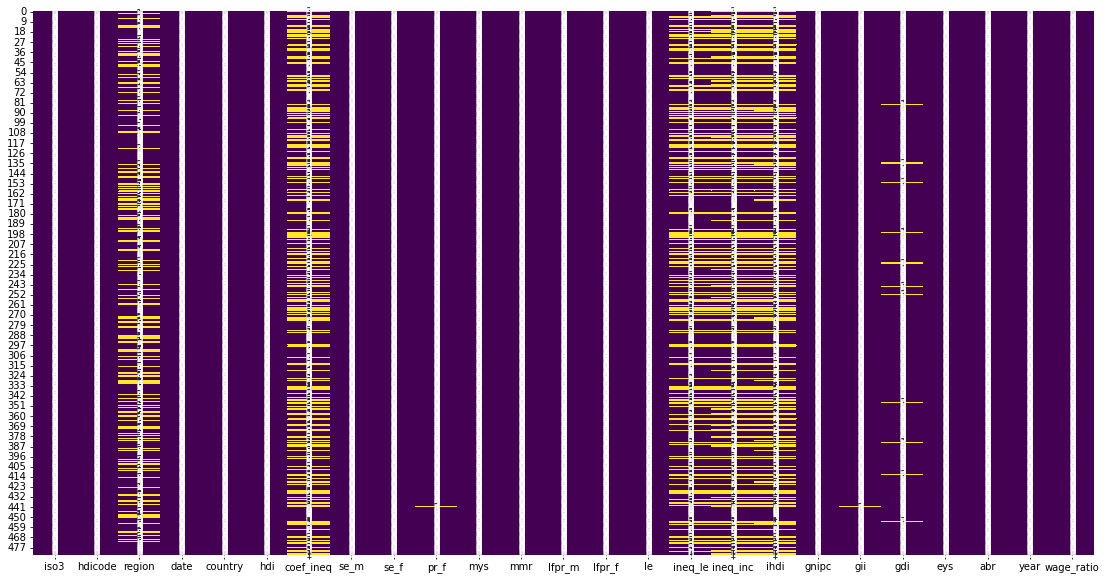

In [23]:
plt.figure(figsize=(19, 10))

# setting the parameter values
sns.heatmap(paygap.isnull(),cbar=False,cmap='viridis', annot = True)

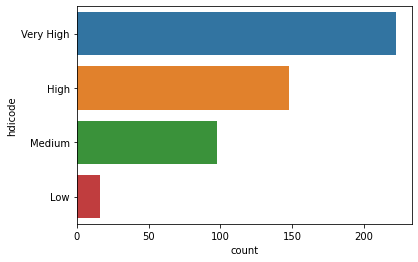

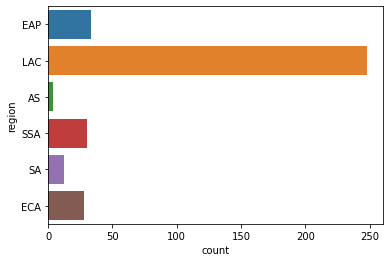

In [24]:
# Plot of each categorical features < 100
for column in paygap.select_dtypes(include='object'):
    if paygap[column].nunique() < 100:
        sns.countplot(y=column, data=paygap)
        plt.show()

# Data Preparation

## Drop selected variables

In [25]:
# Drop selected variables 
paygap.drop(["coef_ineq","ineq_le","ineq_inc","ihdi","iso3","gdi", "gii", "hdi", "hdicode"], axis=1, inplace=True)
paygap.columns

Index(['region', 'date', 'country', 'se_m', 'se_f', 'pr_f', 'mys', 'mmr',
       'lfpr_m', 'lfpr_f', 'le', 'gnipc', 'eys', 'abr', 'year', 'wage_ratio'],
      dtype='object')

## Missing Values

In [26]:
# Fill in missing regions 
region_uniq = paygap["region"].sort_values().unique()
print(f"paygap region : {region_uniq}")

paygap["region"].fillna("No_Region", inplace = True)
paygap["region"].sort_values().unique()

paygap region : ['AS' 'EAP' 'ECA' 'LAC' 'SA' 'SSA' nan]


array(['AS', 'EAP', 'ECA', 'LAC', 'No_Region', 'SA', 'SSA'], dtype=object)

In [27]:
# Fill in the missing remaining values
paygap["pr_f"].fillna(0, inplace = True)

In [28]:
# to know just the missing values
print(paygap.isnull().sum())

region        0
date          0
country       0
se_m          0
se_f          0
pr_f          0
mys           0
mmr           0
lfpr_m        0
lfpr_f        0
le            0
gnipc         0
eys           0
abr           0
year          0
wage_ratio    0
dtype: int64


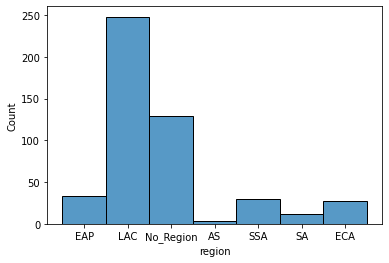

In [29]:
# based on version that replaces null values with 0
# histograms of variable distribution
for column in paygap.select_dtypes(include='object'):
    if paygap[column].nunique() < 100:
        sns.histplot(data = paygap[column])
        plt.show()


The year with the most complete data is: 2014


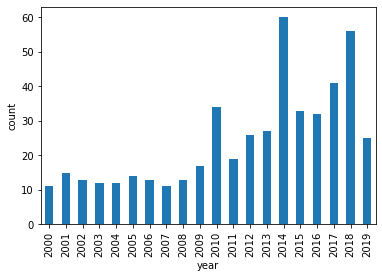

In [30]:
# determine year with the most complete data
count = paygap.groupby(by='year')['wage_ratio'].count()
count.plot.bar()
plt.ylabel('count')
print('The year with the most complete data is:',count.idxmax())

In [31]:
# check for duplicates
print('before dropping duplicates:', paygap.count())

# after dropping duplicates
paygap.drop_duplicates()
print('after dropping duplicates:', paygap.count())

before dropping duplicates: region        484
date          484
country       484
se_m          484
se_f          484
pr_f          484
mys           484
mmr           484
lfpr_m        484
lfpr_f        484
le            484
gnipc         484
eys           484
abr           484
year          484
wage_ratio    484
dtype: int64
after dropping duplicates: region        484
date          484
country       484
se_m          484
se_f          484
pr_f          484
mys           484
mmr           484
lfpr_m        484
lfpr_f        484
le            484
gnipc         484
eys           484
abr           484
year          484
wage_ratio    484
dtype: int64


## Encoding categorical variables

In [32]:
# Make a copy of dataframe for additional transformation
paygap_enc = paygap.copy()

# one-hot encoding of categorical data to integer values except for country
paygap_enc = pd.get_dummies(paygap_enc, columns = ['region'])
paygap_enc.dtypes

date                datetime64[ns]
country                     object
se_m                       float64
se_f                       float64
pr_f                       float64
mys                        float64
mmr                        float64
lfpr_m                     float64
lfpr_f                     float64
le                         float64
gnipc                      float64
eys                        float64
abr                        float64
year                         int64
wage_ratio                 float64
region_AS                    uint8
region_EAP                   uint8
region_ECA                   uint8
region_LAC                   uint8
region_No_Region             uint8
region_SA                    uint8
region_SSA                   uint8
dtype: object

In [33]:
paygap_enc.sample(10)

,date,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,...,abr,year,wage_ratio,region_AS,region_EAP,region_ECA,region_LAC,region_No_Region,region_SA,region_SSA
164,2002-01-01,Colombia,37.397279,37.082956,10.820896,6.967805,92.0,81.760,52.572,71.9389,...,91.952,2002,1.177602,0,0,0,1,0,0,0
441,2014-01-01,Brunei Darussalam,69.554000,67.652000,0.000000,8.970000,29.0,72.217,56.283,74.7788,...,12.266,2014,1.016949,0,1,0,0,0,0,0
255,2015-01-01,Sri Lanka,80.703320,80.377937,4.888889,10.464382,36.0,73.874,35.403,74.9275,...,16.900,2015,0.982773,0,0,0,0,0,1,0
183,2015-01-01,Ecuador,52.246910,52.121620,41.605839,8.701580,63.0,79.643,51.881,76.7893,...,79.692,2015,1.071429,0,0,0,1,0,0,0
331,2013-01-01,Korea (Republic of),90.426700,79.027356,15.666667,11.925082,13.0,73.264,50.621,81.8637,...,3.226,2013,0.670607,0,0,0,0,1,0,0
253,2016-01-01,Finland,96.375268,97.681157,41.500000,12.686525,3.0,62.398,54.990,81.2915,...,5.504,2016,0.836449,0,0,0,0,1,0,0
226,2012-01-01,Ecuador,47.207569,46.487320,32.258065,8.097470,71.0,77.065,48.041,76.0616,...,90.001,2012,0.923077,0,0,0,1,0,0,0
132,2018-01-01,Albania,92.903100,94.975638,27.857143,11.096983,15.0,67.247,51.189,79.1838,...,15.580,2018,0.930693,0,0,1,0,0,0,0
234,2013-01-01,Bosnia and Herzegovina,77.899590,56.158192,19.298246,8.542043,10.0,54.909,32.360,76.3304,...,10.863,2013,0.926829,0,0,1,0,0,0,0
424,2018-01-01,Korea (Republic of),92.640352,82.389127,17.000000,12.412579,11.0,73.636,53.137,83.3427,...,2.363,2018,0.685288,0,0,0,0,1,0,0


# More Data Exploration

## Correlation Matrices

### Correlation Heatmaps per Year

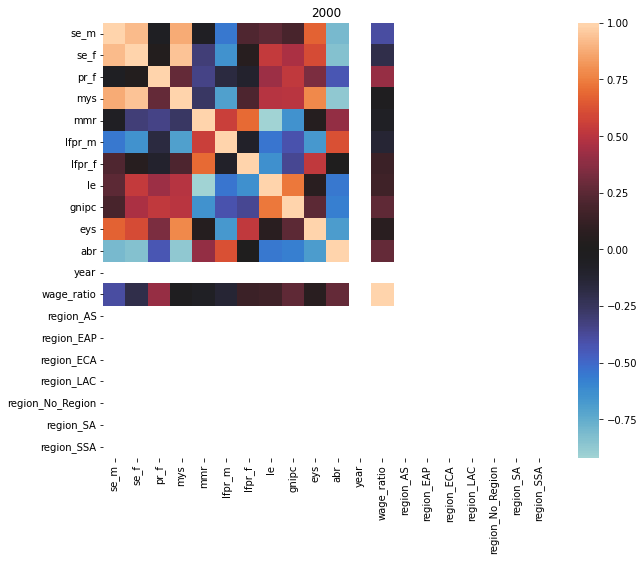

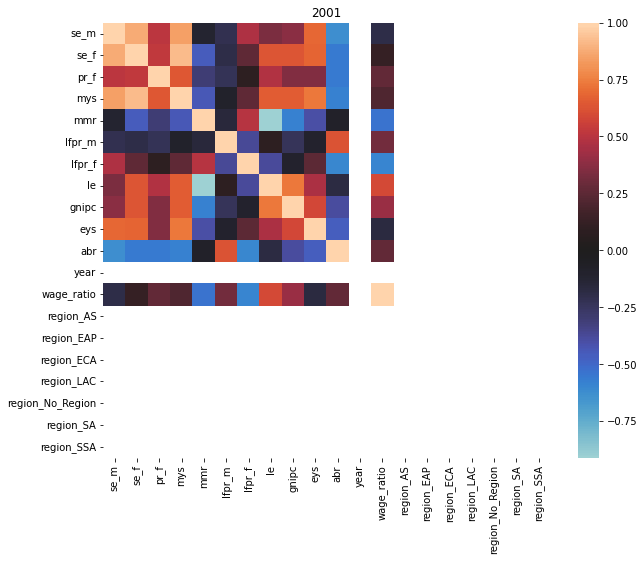

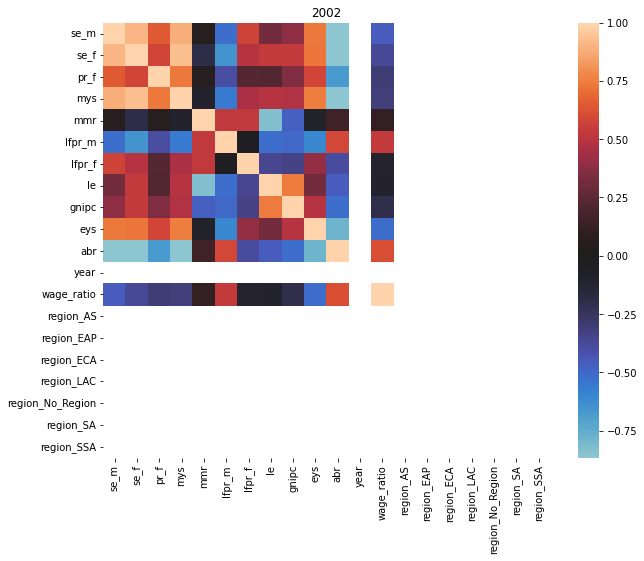

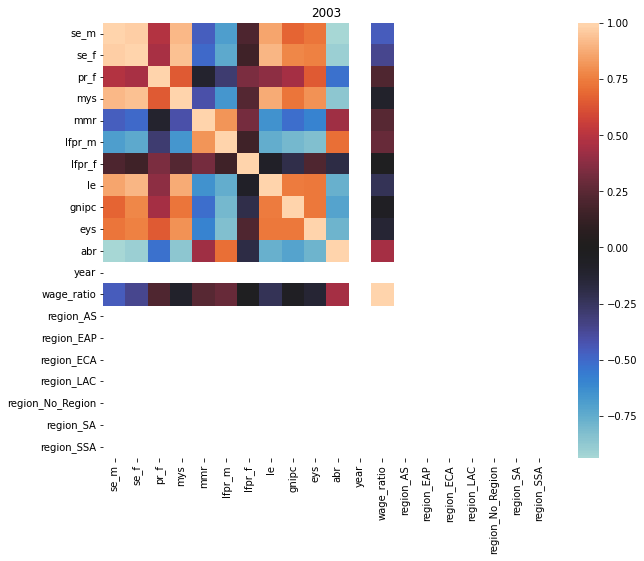

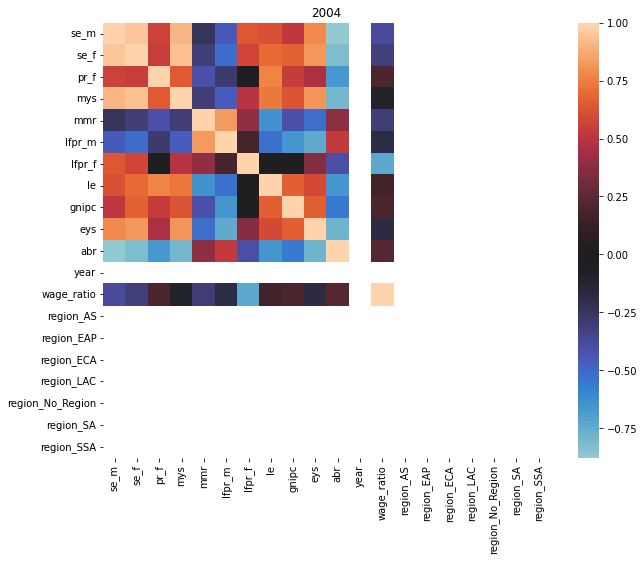

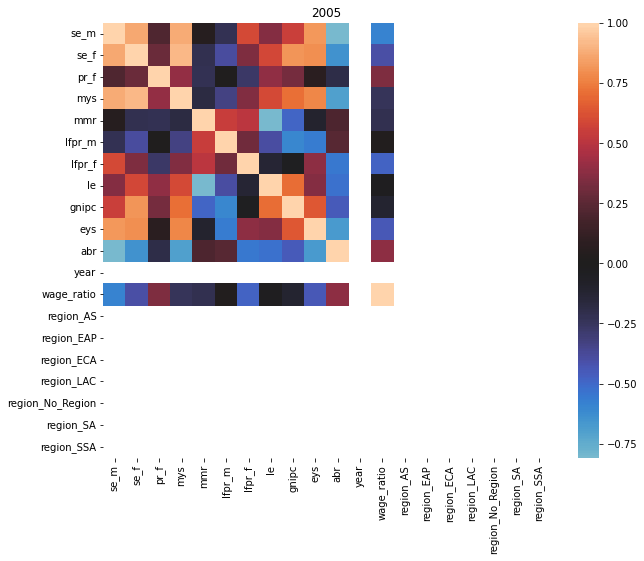

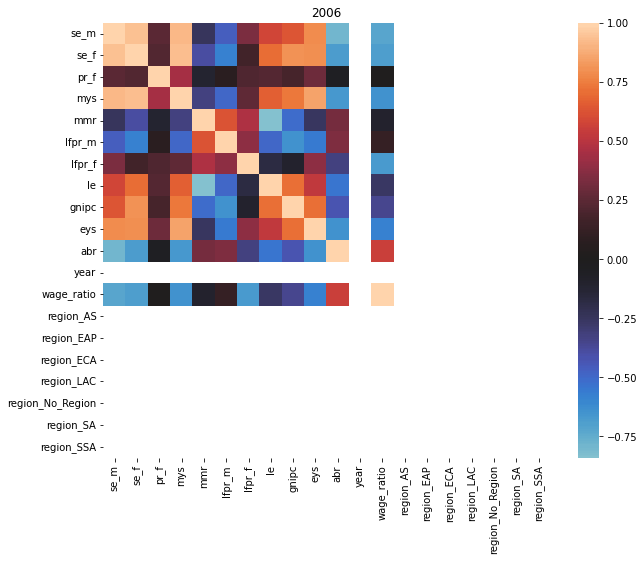

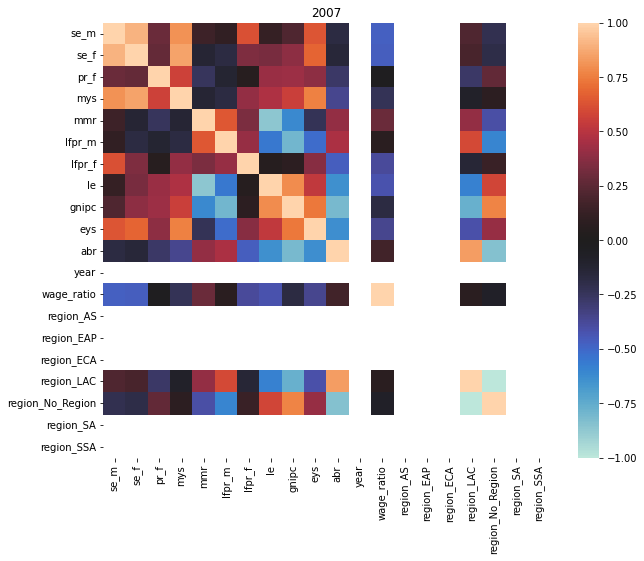

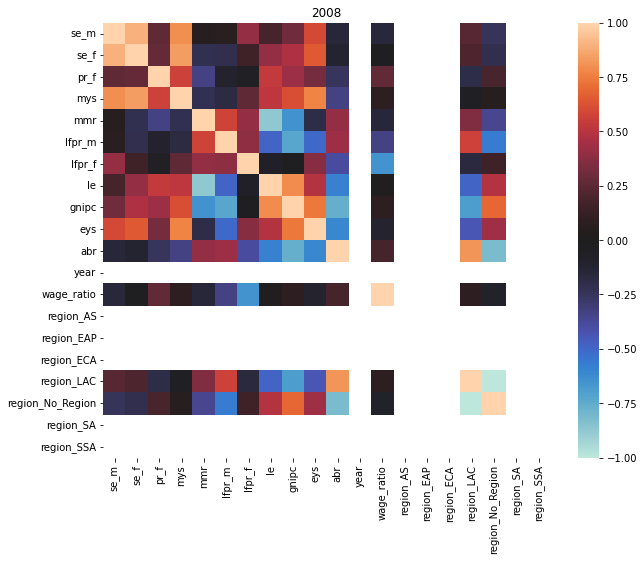

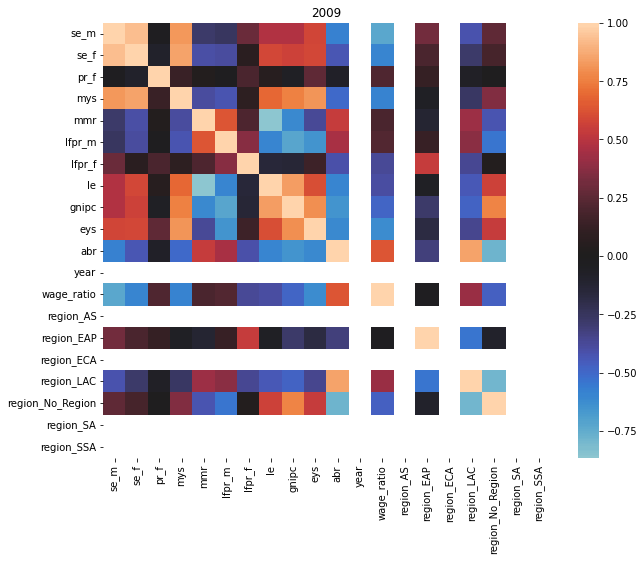

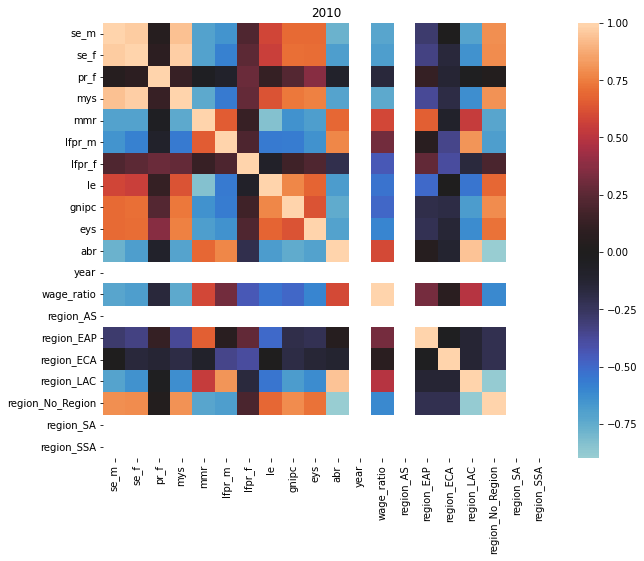

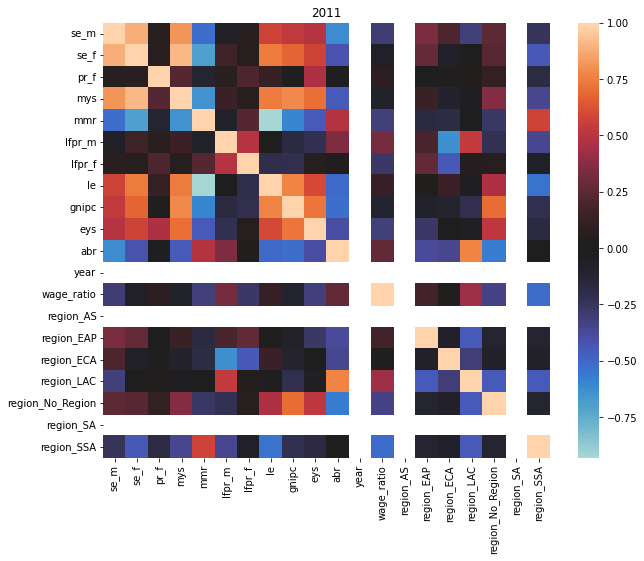

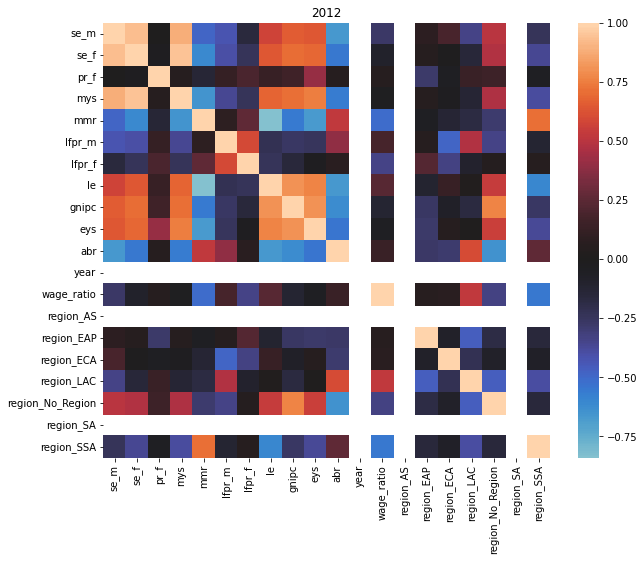

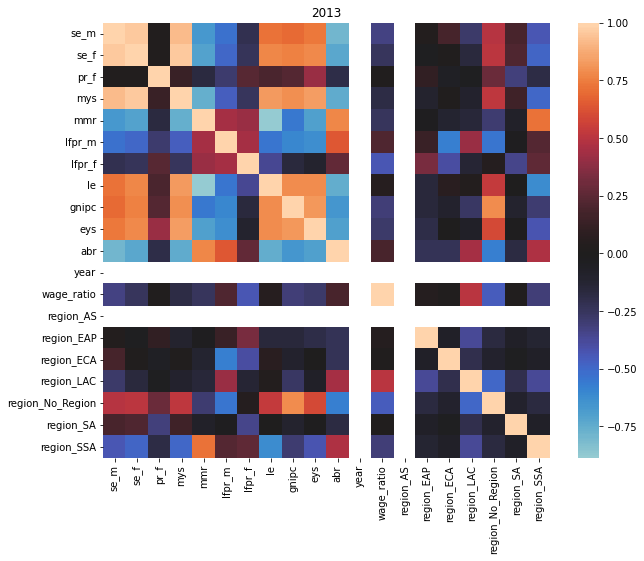

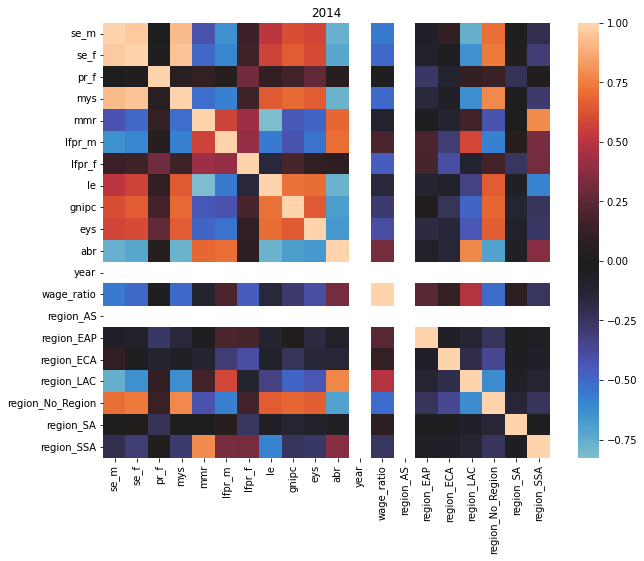

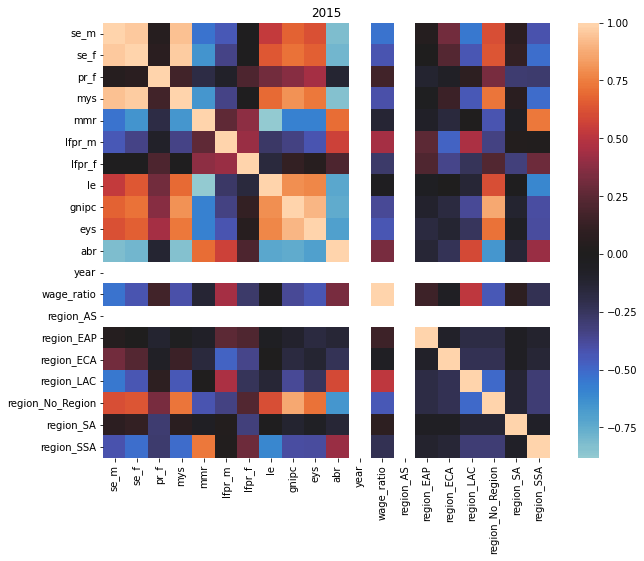

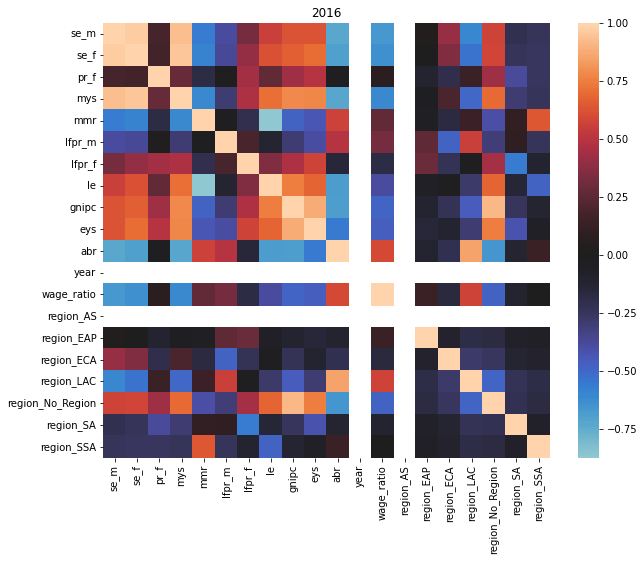

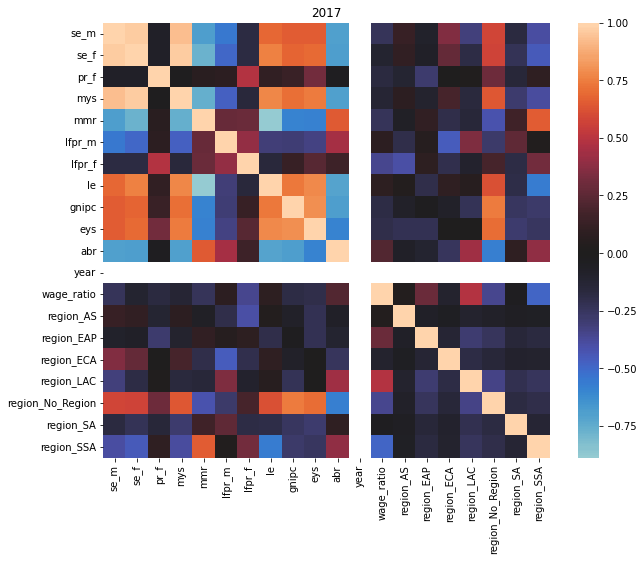

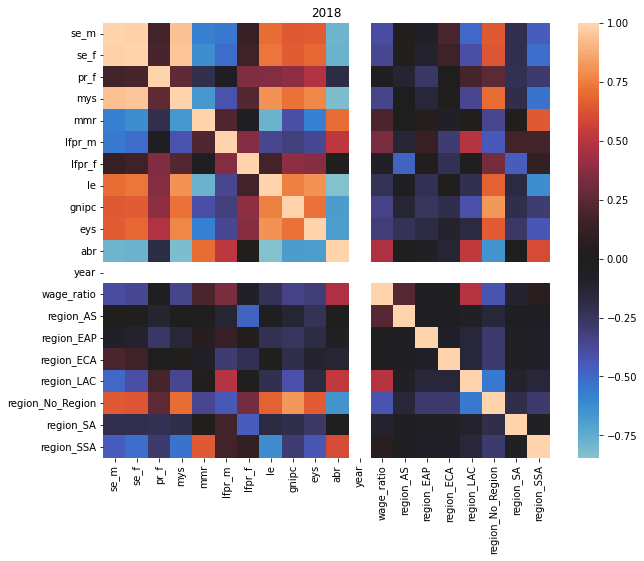

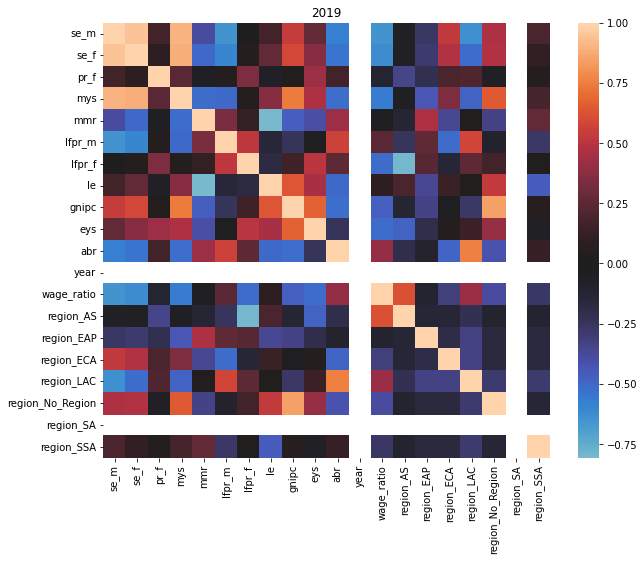

In [34]:
# Visualize the correlation matrices for each year
for year in np.sort(paygap_enc['year'].unique()):
  corr_matrix = paygap_enc.loc[paygap_enc['year']==year].corr()
  fig, ax = plt.subplots(figsize=(10,8)) 
  sns.heatmap(data = corr_matrix, center = 0)
  plt.title(str(year))

### Correlation Matrices and Summary Stats for Select Years

#### 2018

In [35]:
# Correlation Matrix for 2018
paygap_18 = paygap.loc[paygap['year']==2018] # Create a DF of just 2018 data
corr_matrix_18 = paygap_18.corr()
corr_matrix_18

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
se_m,1.000000,0.981660,0.171646,0.941297,-0.571737,-0.551850,0.134575,0.699518,0.649015,0.655315,-0.783920,NaN,-0.391325
se_f,0.981660,1.000000,0.191439,0.952364,-0.623976,-0.506302,0.161427,0.727849,0.660380,0.686719,-0.773502,NaN,-0.368304
pr_f,0.171646,0.191439,1.000000,0.263154,-0.206825,-0.038284,0.356835,0.365121,0.381904,0.480187,-0.188275,NaN,-0.028980
mys,0.941297,0.952364,0.263154,1.000000,-0.666017,-0.414150,0.223323,0.808494,0.725585,0.769793,-0.817663,NaN,-0.340548
mmr,-0.571737,-0.623976,-0.206825,-0.666017,1.000000,0.208900,-0.042235,-0.773460,-0.402562,-0.575055,0.697878,NaN,0.196952
lfpr_m,-0.551850,-0.506302,-0.038284,-0.414150,0.208900,1.000000,0.361853,-0.358293,-0.314176,-0.363304,0.517608,NaN,0.340403
lfpr_f,0.134575,0.161427,0.356835,0.223323,-0.042235,0.361853,1.000000,0.164763,0.386278,0.372972,0.017623,NaN,-0.078531
le,0.699518,0.727849,0.365121,0.808494,-0.773460,-0.358293,0.164763,1.000000,0.759313,0.805614,-0.843709,NaN,-0.230773
gnipc,0.649015,0.660380,0.381904,0.725585,-0.402562,-0.314176,0.386278,0.759313,1.000000,0.724479,-0.684802,NaN,-0.334394
eys,0.655315,0.686719,0.480187,0.769793,-0.575055,-0.363304,0.372972,0.805614,0.724479,1.000000,-0.688324,NaN,-0.305829


In [36]:
# Average values by Developing Region for 2018
paygap_18.groupby('region').mean()

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
region,,,,,,,,,,,,,
AS,84.076881,77.870293,15.384615,10.350900,46.000000,62.861000,14.976000,75.774300,9967.349228,10.416770,27.314000,2018.0,1.111111
EAP,71.514031,66.582084,15.045066,9.109416,93.500000,72.637500,51.975500,71.715850,11236.340565,13.246094,24.064500,2018.0,0.896915
ECA,93.450284,88.125188,24.912657,10.852665,15.750000,62.078000,43.093000,76.963100,14276.336735,14.072328,14.758750,2018.0,0.895830
LAC,56.427325,56.743422,28.962302,8.647278,71.000000,76.102333,51.496583,74.067733,13265.205315,14.245559,64.014667,2018.0,1.018655
No_Region,91.843696,89.380918,27.860407,12.224626,6.793103,66.489586,54.406448,80.687572,44462.496515,16.878771,9.508069,2018.0,0.864085
SA,53.451542,49.295775,12.888889,7.733620,88.000000,75.712000,27.364500,71.115000,8583.811331,11.193505,30.400000,2018.0,0.849502
SSA,40.735015,30.895427,13.959034,5.406432,433.500000,73.834750,55.120000,62.533375,7947.520582,10.793883,102.254000,2018.0,0.937583


In [37]:
# Top 10 Wage Ratio countries in 2018
paygap_18.nlargest(10,'wage_ratio')

,region,date,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
285,LAC,2018-01-01,Honduras,29.810511,32.328609,21.093750,6.287880,65.0,83.189,50.167,72.8141,5248.923663,9.838729,74.666,2018,1.280597
117,LAC,2018-01-01,Belize,56.694470,60.341237,11.111111,9.175324,36.0,79.353,49.076,73.7031,6699.038968,13.149050,72.062,2018,1.171429
279,AS,2018-01-01,Jordan,84.076881,77.870293,15.384615,10.350900,46.0,62.861,14.976,75.7743,9967.349228,10.416770,27.314,2018,1.111111
178,LAC,2018-01-01,Dominican Republic,73.277578,74.079707,24.324324,9.106114,95.0,77.529,50.230,73.2323,16958.433050,14.344020,83.874,2018,1.106164
97,SSA,2018-01-01,Chad,23.415501,7.278934,15.254237,2.479598,1140.0,71.518,48.462,52.8253,1553.131495,7.858483,144.658,2018,1.079547
80,LAC,2018-01-01,Ecuador,52.846977,52.662551,37.956204,8.782986,59.0,79.042,54.466,77.0938,11242.312150,14.833170,71.383,2018,1.066667
362,SSA,2018-01-01,Zambia,54.608401,43.993152,17.964072,7.058785,213.0,78.786,69.793,62.3422,3418.096158,10.928366,124.849,2018,1.063492
219,LAC,2018-01-01,Costa Rica,53.456581,55.530479,45.614035,8.723170,27.0,74.159,46.482,79.4835,19562.359990,15.866720,51.147,2018,1.052311
479,LAC,2018-01-01,Argentina,70.853092,70.391372,39.513678,11.104700,39.0,70.717,49.316,76.9994,21924.731190,17.656179,51.029,2018,1.015504
319,LAC,2018-01-01,Paraguay,51.015308,49.248611,16.000000,8.585580,84.0,84.127,59.247,73.5676,12402.409120,12.752628,73.670,2018,1.014747


In [38]:
# Bottom 10 Wage Ratio countries in 2018
paygap_18.nsmallest(10,'wage_ratio')

,region,date,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
424,No_Region,2018-01-01,Korea (Republic of),92.640352,82.389127,17.000000,12.412579,11.0,73.636,53.137,83.3427,42115.211320,16.493959,2.363,2018,0.685288
312,LAC,2018-01-01,Guyana,61.228578,67.655681,31.884058,8.513898,169.0,66.153,42.152,68.8959,12575.034960,12.343697,69.664,2018,0.693064
392,SSA,2018-01-01,Burkina Faso,15.741910,9.934090,11.023622,1.919520,320.0,73.434,57.782,60.0466,2050.921164,9.273730,115.166,2018,0.761029
190,SA,2018-01-01,Pakistan,24.009041,15.749600,20.000000,4.825690,140.0,79.057,21.508,66.4820,4657.880392,8.275940,44.908,2018,0.763441
167,No_Region,2018-01-01,Estonia,97.449408,96.590824,26.732673,13.656310,9.0,71.267,57.363,78.1395,34552.404420,15.910490,9.404,2018,0.777778
40,EAP,2018-01-01,Tonga,92.911004,93.309330,7.407407,11.362268,52.0,55.707,38.047,70.7787,6790.395096,15.869467,19.220,2018,0.783784
277,No_Region,2018-01-01,Austria,100.000000,100.000000,34.836066,12.207905,5.0,67.106,55.907,81.6862,54587.744450,16.066750,5.855,2018,0.800000
467,No_Region,2018-01-01,France,87.340656,82.714767,35.714286,11.509880,8.0,60.203,51.424,82.5909,46162.657900,15.743010,8.166,2018,0.800000
165,No_Region,2018-01-01,United Kingdom,99.796557,99.736771,28.938237,13.242927,7.0,68.345,58.026,81.1254,46225.878330,17.248051,12.338,2018,0.802198
29,No_Region,2018-01-01,Czechia,99.775143,99.859867,20.284698,12.828065,3.0,68.723,52.782,79.0039,37668.166780,16.238991,10.590,2018,0.807547


#### 2014

In [39]:
# Correlation Matrix for 2014
paygap_14 = paygap.loc[paygap['year']==2014] # Create a df of just 2014 data
corr_matrix_14 = paygap_14.corr()
corr_matrix_14

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
se_m,1.000000,0.962729,0.000759,0.923144,-0.416782,-0.634188,0.143602,0.510954,0.608872,0.586086,-0.765334,NaN,-0.558139
se_f,0.962729,1.000000,0.009006,0.943515,-0.495581,-0.591176,0.158374,0.573289,0.655701,0.606983,-0.728819,NaN,-0.504629
pr_f,0.000759,0.009006,1.000000,0.069780,0.109519,0.052147,0.304130,0.102494,0.168205,0.270707,0.051796,NaN,-0.039943
mys,0.923144,0.943515,0.069780,1.000000,-0.514668,-0.576314,0.152822,0.646680,0.695970,0.663766,-0.773509,NaN,-0.499828
mmr,-0.416782,-0.495581,0.109519,-0.514668,1.000000,0.571522,0.427862,-0.825694,-0.440139,-0.487603,0.691154,NaN,-0.110155
lfpr_m,-0.634188,-0.591176,0.052147,-0.576314,0.571522,1.000000,0.406474,-0.556654,-0.414010,-0.529936,0.714720,NaN,0.194969
lfpr_f,0.143602,0.158374,0.304130,0.152822,0.427862,0.406474,1.000000,-0.153148,0.193997,0.098402,0.082997,NaN,-0.453810
le,0.510954,0.573289,0.102494,0.646680,-0.825694,-0.556654,-0.153148,1.000000,0.717712,0.702797,-0.770853,NaN,-0.155093
gnipc,0.608872,0.655701,0.168205,0.695970,-0.440139,-0.414010,0.193997,0.717712,1.000000,0.648997,-0.683660,NaN,-0.283180
eys,0.586086,0.606983,0.270707,0.663766,-0.487603,-0.529936,0.098402,0.702797,0.648997,1.000000,-0.665987,NaN,-0.393849


In [40]:
# Top 10 Wage Ratio countries in 2014
paygap_14.nlargest(10,'wage_ratio')

,region,date,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
44,LAC,2014-01-01,Honduras,31.196430,33.451851,25.781250,6.175800,68.0,82.613,46.178,72.2594,4783.560934,9.675360,79.562,2014,1.150510
443,LAC,2014-01-01,Guatemala,29.901293,23.814733,13.291139,5.836990,107.0,82.843,40.255,71.9638,7734.793394,10.703600,81.595,2014,1.139706
239,LAC,2014-01-01,Ecuador,49.364609,48.244808,41.605839,8.361360,65.0,77.803,47.656,76.6221,11887.546000,15.055005,80.124,2014,1.074074
365,LAC,2014-01-01,Argentina,67.674676,67.233668,37.082067,10.908510,42.0,72.283,47.600,76.7549,23087.869640,17.270140,67.791,2014,1.036199
333,ECA,2014-01-01,Turkey,65.925194,44.243881,14.416058,7.795050,19.0,71.730,30.448,76.5648,24762.235740,16.921440,28.912,2014,1.018018
354,EAP,2014-01-01,Malaysia,74.506401,69.825391,14.234875,10.143660,30.0,77.617,50.128,75.1459,23108.648300,13.451900,13.434,2014,1.017857
441,EAP,2014-01-01,Brunei Darussalam,69.554000,67.652000,0.000000,8.970000,29.0,72.217,56.283,74.7788,64338.126010,14.875150,12.266,2014,1.016949
296,LAC,2014-01-01,El Salvador,45.618961,38.704887,27.380952,6.528740,49.0,75.104,45.875,71.7464,7634.715924,12.548150,70.115,2014,1.000000
283,LAC,2014-01-01,Nicaragua,44.060000,45.728000,42.391304,6.544000,103.0,83.162,47.948,72.8121,5257.845956,11.631528,94.226,2014,0.973810
155,LAC,2014-01-01,Panama,63.903123,66.127359,19.298246,9.838257,60.0,77.255,48.125,77.2478,24968.406560,12.706840,90.182,2014,0.955556


In [41]:
# Bottom 10 Wage Ratio countries in 2014
paygap_14.nsmallest(10,'wage_ratio')

,region,date,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,year,wage_ratio
172,No_Region,2014-01-01,Korea (Republic of),90.864290,79.686263,16.333333,12.020706,12.0,74.090,51.803,82.3781,38144.210840,16.645460,3.174,2014,0.661959
43,SSA,2014-01-01,Cameroon,51.017439,31.662842,27.142857,5.782896,564.0,81.892,70.543,58.9355,3443.009493,11.837320,119.042,2014,0.674510
380,No_Region,2014-01-01,Estonia,96.061679,94.665646,19.000000,13.442950,11.0,68.860,54.574,77.1406,29532.966080,16.219891,15.380,2014,0.724638
153,No_Region,2014-01-01,Germany,97.090340,96.525703,35.571429,14.037120,5.0,66.324,54.774,80.9151,51268.872700,16.735340,8.114,2014,0.773869
162,No_Region,2014-01-01,Austria,100.000000,99.141281,31.428571,12.014500,5.0,66.416,55.298,81.3903,52720.297690,15.855730,7.947,2014,0.778409
182,No_Region,2014-01-01,Czechia,99.816116,99.814880,18.505338,12.638140,4.0,68.198,50.858,78.7550,32119.855590,16.748440,12.123,2014,0.792519
2,No_Region,2014-01-01,United Kingdom,99.926178,99.795212,23.023093,12.888980,8.0,68.607,57.019,81.1602,43236.642350,17.485910,15.983,2014,0.792899
103,LAC,2014-01-01,Peru,67.584900,56.291901,22.307692,9.151890,96.0,85.020,69.363,75.3334,11339.084170,14.452218,62.668,2014,0.794872
330,No_Region,2014-01-01,Slovakia,99.501228,99.200752,18.666667,12.443600,5.0,68.250,51.102,76.8470,27334.583860,14.803980,23.008,2014,0.796610
415,No_Region,2014-01-01,Iceland,98.259336,97.865421,39.682540,12.725678,5.0,80.390,72.150,82.6133,46529.703400,19.589769,8.199,2014,0.800643


## Plots

### Scatter Plots - over time

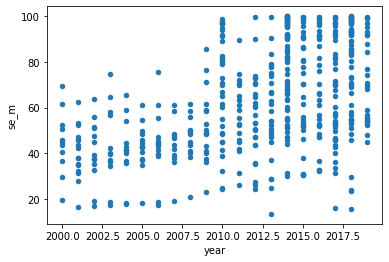

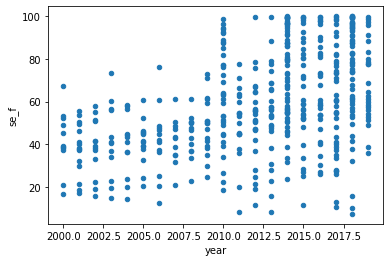

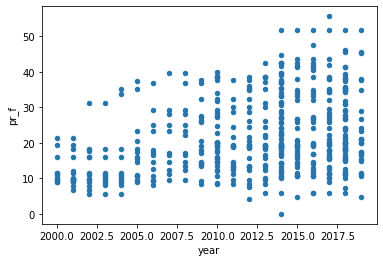

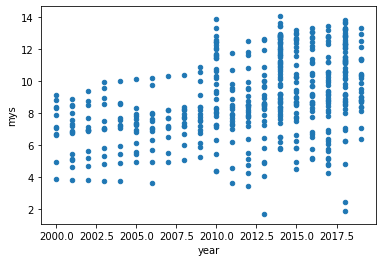

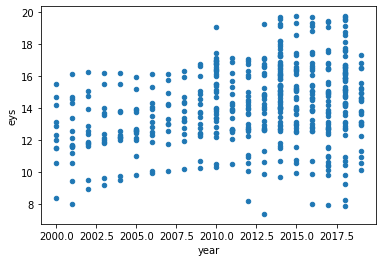

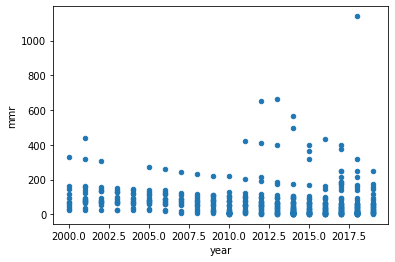

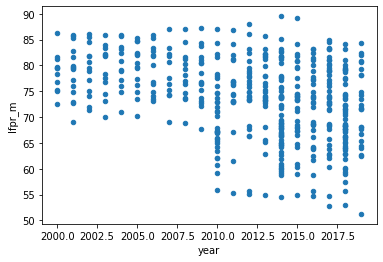

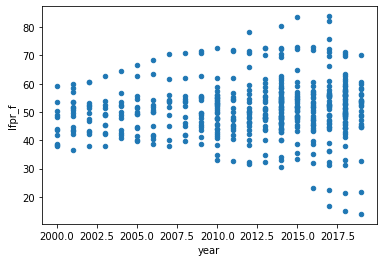

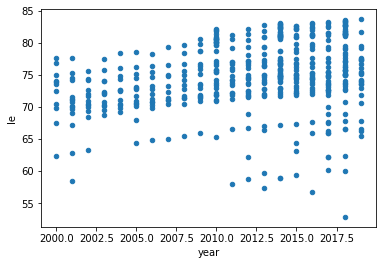

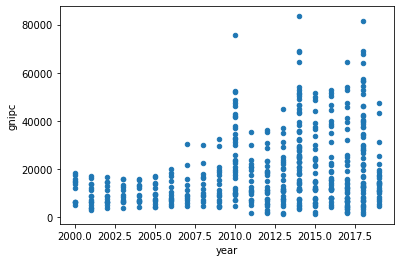

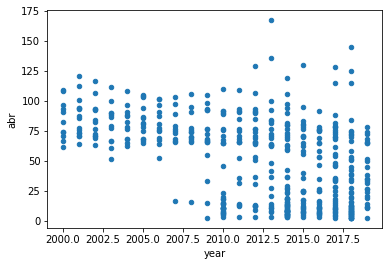

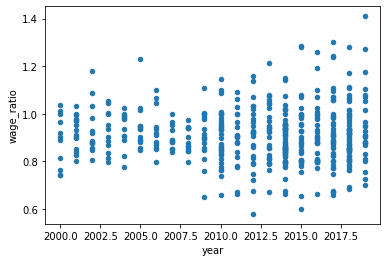

In [42]:
# Plot a scatter matrix to show the distribution of each X var over time
vars = ['se_m','se_f','pr_f','mys','eys','mmr','lfpr_m','lfpr_f','le','gnipc','abr','wage_ratio']

for var in vars:
  paygap.plot.scatter(y = var, x = 'year')

### Scatter Matrix (pairs plot)

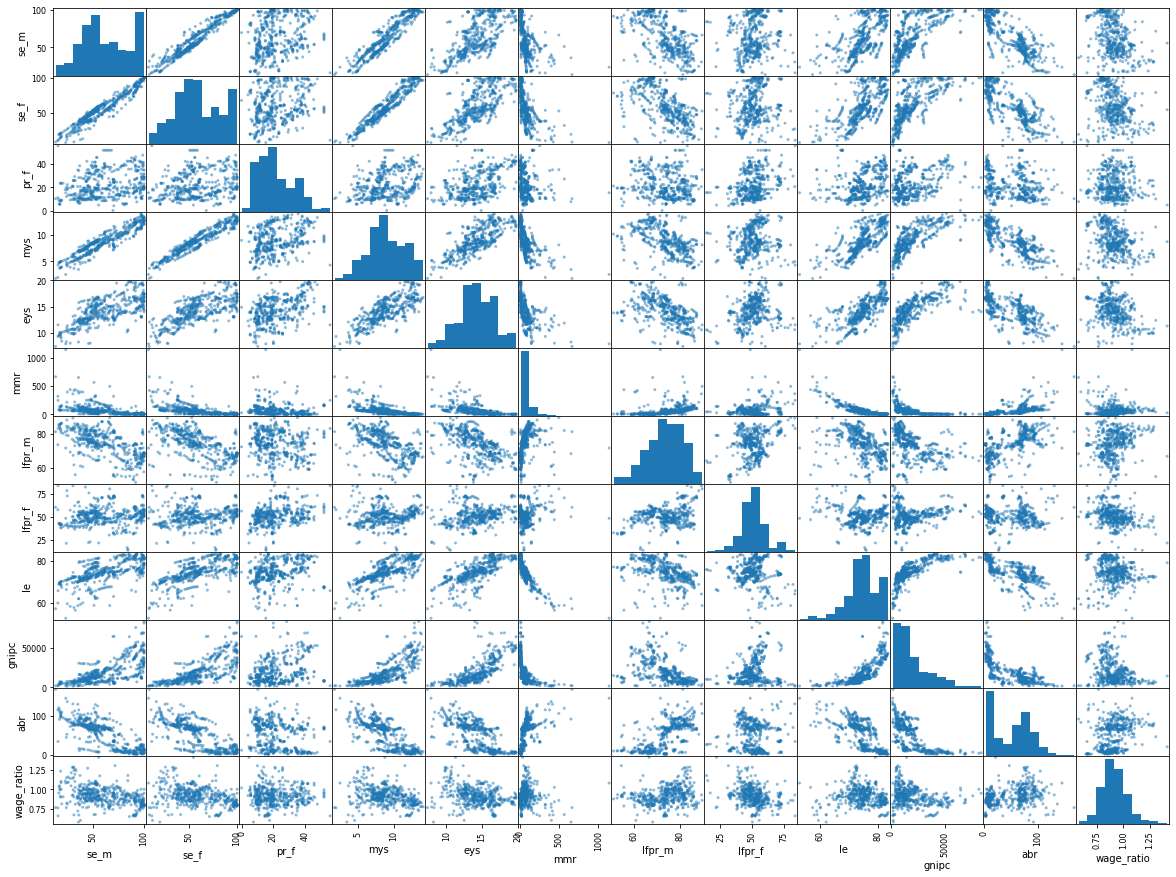

In [43]:
# Plot a scatter matrix for all variables for all years
scatter_matrix(paygap[vars], figsize=(20,15))
plt.show()

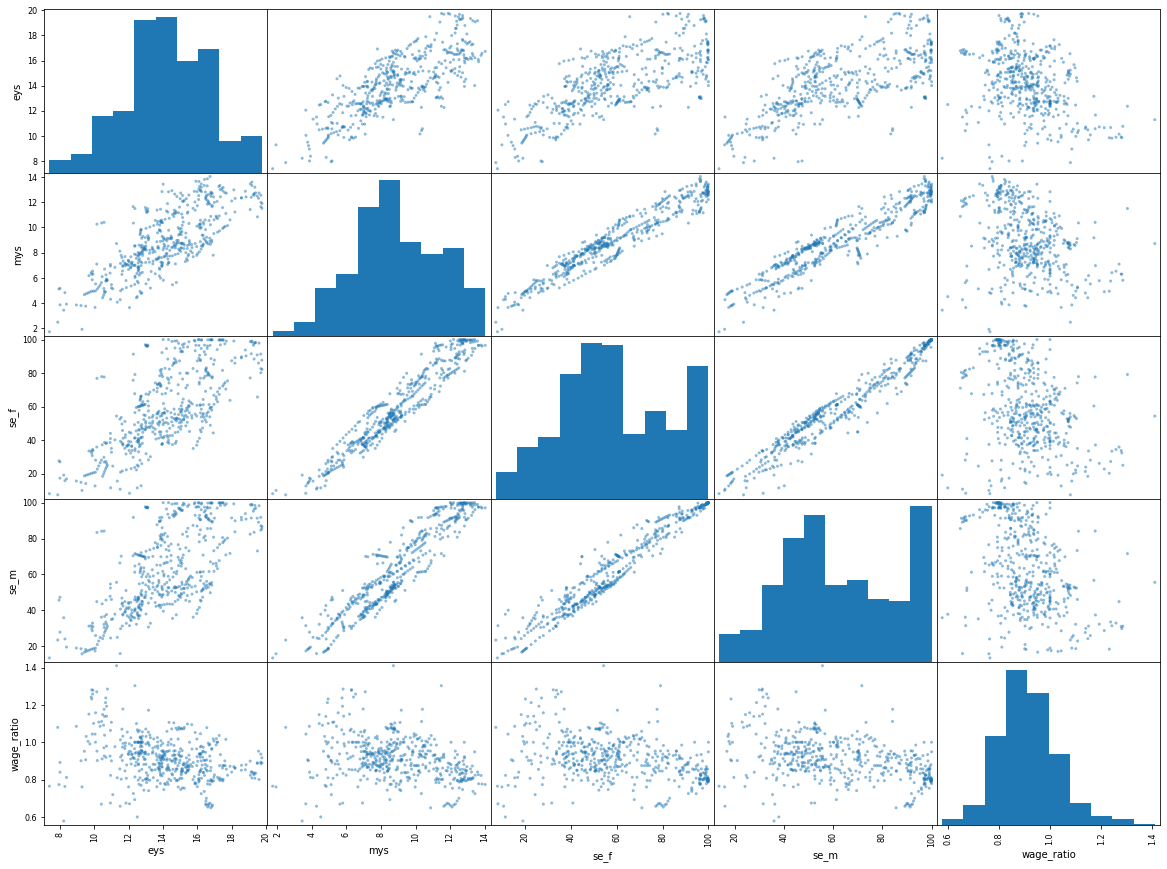

In [44]:
# Plot a scatter matrix of just the education related variables accross all years
education = ['eys','mys','se_f','se_m','wage_ratio']
scatter_matrix(paygap[education], figsize=(20,15))
plt.show()

# Train/Test split

## Split the encoded paygap dataset by year

In [45]:
# Note: This train/test is provided as a template, however each modeling method may require differnt types of train/test split.
# Please create a train/test split as part of the Modeling section that meets the needs of the speficic model


# Split the data into train/test sets based on year
#year = 2016
#paygap_train_time = paygap_enc.loc[paygap_enc['date'].dt.year <= year]
#paygap_test_time = paygap_enc.loc[paygap_enc['date'].dt.year > year]

#print(len(paygap_train_time))
#print(len(paygap_train_time)/len(paygap_enc))
#print(len(paygap_test_time))

# Principal Component Analysis (PCA)
## By implementing the Factorial Analysis of Mixed Data (FAMD)

FAMD generalizes PCA for datasets containing both numerical and categorical values.

For more information, please see [here](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210), and an example of the application of FAMD [here](https://medium.com/fifty-five-data-science/how-to-delete-bias-in-your-dataset-before-applying-a-clustering-ff1dfd14d179).

Steps of FAMD:

1. Standardize numerical columns by obtaining the z-score
2. Divide one-hot encoded categorical columns by the square root of its probability
3. Center the columns
4. Apply PCA on the new table

More resources:
[Plot for explained variance](https://vitalflux.com/pca-explained-variance-concept-python-example/), [2D projection of PCA](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60), [Centering data for categorical variables](https://www.statology.org/center-data-in-python/)

Have not implemented yet:
[Visualize all the original dimensions](https://plotly.com/python/pca-visualization/), [PCA for time-series](https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data)

In [46]:
from scipy import stats

In [47]:
# # feature extraction with Principal Component Analysis (PCA)
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# # split data into training and testing set
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(paygap.select_dtypes('float'),test_size = 0.2, random_state = 0)

In [48]:
# print(pca.components_)

In [49]:
# print(pca.explained_variance_)

In [50]:
# print(pca.explained_variance_ratio_)

In [51]:
# numerical variables
X_n = pd.DataFrame(paygap.select_dtypes('float64'))
target = X_n['wage_ratio']
X_n = X_n.drop(columns=['wage_ratio'])
X_n.sample(10)
# standard scale the numerical variables
X_n_nor = stats.zscore(X_n)
X_n_nor.sample(10)

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr
342,-0.667291,-0.535348,-0.464850,-0.263773,0.177401,0.975550,0.337073,-0.344105,-0.542938,-0.516668,0.740782
202,0.167119,-0.090087,2.724322,0.284478,0.803205,0.817521,1.289800,-1.305181,-0.723683,0.347278,0.443010
295,1.258165,1.401152,-0.173329,1.555353,-0.634188,-1.025426,-0.112894,1.097669,3.656396,-0.095919,-1.246601
7,-0.163478,-0.021791,1.069202,0.433878,-0.115944,0.145473,-0.077461,0.026334,-0.228177,0.843299,0.333214
405,-0.967748,-0.947525,-1.120773,-0.691153,0.695645,1.539739,0.595560,-0.793158,-0.797212,-0.820316,0.725974
76,0.029800,-0.228088,2.724322,0.099075,0.861874,0.526222,0.616576,-1.327720,-0.748895,0.133994,0.510528
327,-1.916895,-1.893536,-1.245777,-2.047242,0.627198,1.561907,-0.858912,-1.039736,-0.845941,-1.918750,1.290445
80,-0.421688,-0.265922,1.462488,-0.051558,-0.135501,0.686196,0.362150,0.445804,-0.541582,0.272399,0.583706
200,0.043173,-0.167072,-0.325163,-0.171477,0.578307,0.906583,0.994255,-0.572097,-0.848238,-0.530152,0.508727
358,-0.730410,-0.891697,-1.062045,-1.061820,1.732132,0.342264,-0.287520,-1.545633,-0.990967,-1.433959,-0.513821


In [52]:
# categorical variables
X_c = pd.DataFrame(paygap.select_dtypes('object'))
X_c.sample(10)
# one-hot encode columns
X_c_nor = pd.get_dummies(X_c)
X_c_nor.sample(10)

,region_AS,region_EAP,region_ECA,region_LAC,region_No_Region,region_SA,region_SSA,country_Albania,country_Argentina,country_Armenia,...,country_Tonga,country_Turkey,country_Uganda,country_Ukraine,country_United Kingdom,country_Uruguay,country_Venezuela (Bolivarian Republic of),country_Viet Nam,country_Zambia,country_Zimbabwe
433,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
460,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
171,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
429,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# probability for each one-hot encoded column
# 129 columns in total
# derive probability for each column
import math
probability = [] #square root of probability
for (columnname, columnData) in X_c_nor.iteritems():
  # print(columnData.values)
  p = math.sqrt(sum(columnData.values)/len(columnData.values))
  probability.append(p) 
print(probability)
print(len(probability))
# transform X_c_nor
test = X_c_nor / probability
print(test)
# center the columns
#create function to center data
center_function = lambda x: x - x.mean()
#apply function to original NumPy array
data_centered = center_function(test)

[0.09090909090909091, 0.26111648393354675, 0.24052284646041733, 0.7158188976374373, 0.5162643950727521, 0.1574591643244434, 0.2489647988659846, 0.045454545454545456, 0.18181818181818182, 0.11134044285378082, 0.0787295821622217, 0.045454545454545456, 0.045454545454545456, 0.10163945352271772, 0.0787295821622217, 0.18741389207353001, 0.14373989364401724, 0.045454545454545456, 0.19284730395996752, 0.0642824346533225, 0.0642824346533225, 0.045454545454545456, 0.045454545454545456, 0.045454545454545456, 0.045454545454545456, 0.045454545454545456, 0.128564869306645, 0.10163945352271772, 0.17604469755488258, 0.045454545454545456, 0.0787295821622217, 0.12026142323020866, 0.0642824346533225, 0.17604469755488258, 0.18741389207353001, 0.19813177016093972, 0.0787295821622217, 0.045454545454545456, 0.10163945352271772, 0.0787295821622217, 0.045454545454545456, 0.0642824346533225, 0.045454545454545456, 0.0787295821622217, 0.16388869433927225, 0.045454545454545456, 0.045454545454545456, 0.19284730395

In [54]:
# # scale the dataset
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X = pd.concat([X_n,test],axis=1)
# sc.fit(X)
# X_nor = sc.transform(X)
# print(X_nor)
# X = X_nor

In [55]:
X=pd.concat([X_n_nor,data_centered],axis=1)
X=pd.concat([X_n_nor,X_c_nor],axis=1)
X.sample(10)

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,...,country_Tonga,country_Turkey,country_Uganda,country_Ukraine,country_United Kingdom,country_Uruguay,country_Venezuela (Bolivarian Republic of),country_Viet Nam,country_Zambia,country_Zimbabwe
175,-0.068924,0.199445,-1.225474,0.199812,0.030729,0.383619,-0.668651,0.358328,0.166954,-0.619660,...,0,0,0,0,0,0,0,0,0,0
220,-0.609885,-0.377690,-0.433616,-0.672847,0.216514,-0.206367,-1.223089,-0.532715,-0.523636,-0.486472,...,0,0,0,0,0,0,0,0,0,0
112,0.318966,-0.596868,-0.556910,-0.714523,-0.604853,-2.308592,-1.817325,0.441888,-0.549759,-0.315048,...,0,0,0,0,0,0,0,0,0,0
324,0.799075,0.578533,-0.693903,0.877532,-0.653744,-0.770686,-0.814139,1.502937,1.030631,0.510134,...,0,0,0,0,0,0,0,0,0,0
401,1.237607,1.342705,1.972359,1.416940,-0.673301,-0.787279,1.025120,1.447105,2.165899,2.178065,...,0,0,0,0,0,0,0,0,0,0
237,-0.756511,-0.518230,-0.433616,-0.682049,0.187179,-0.036800,-0.928661,-0.572678,-0.521047,-0.575368,...,0,0,0,0,0,0,0,0,0,0
228,0.810269,0.805945,-0.553875,0.665243,-0.585297,-0.282984,-0.218989,1.055889,0.253367,0.934123,...,0,0,0,0,0,0,0,0,0,0
435,-0.065506,0.073398,1.410544,0.470311,-0.135501,0.148584,-0.164368,0.079524,-0.149275,0.737481,...,0,0,0,0,0,0,0,0,0,0
470,1.611470,1.730225,-0.173329,1.551396,-0.663522,-1.273814,0.496064,1.328191,4.023666,0.060136,...,0,0,0,0,0,0,0,0,0,0
161,-1.094054,-1.459712,-1.019261,-1.313219,-0.106166,0.326319,-0.665808,-0.800764,-0.839633,-0.661818,...,0,0,0,0,0,0,0,0,0,0


[5.36503247e-01 1.19619315e-01 7.88878874e-02 6.20317799e-02
 3.84362235e-02 2.87729041e-02 2.50317632e-02 1.32615166e-02
 8.61743320e-03 6.36728361e-03 5.48890279e-03 4.74192367e-03
 4.64583797e-03 3.35058068e-03 3.31620842e-03 3.06144472e-03
 2.81439677e-03 2.60146266e-03 2.58289850e-03 2.32593145e-03
 2.27316937e-03 2.13976699e-03 1.91438632e-03 1.84119809e-03
 1.70619315e-03 1.56787180e-03 1.39391914e-03 1.29133448e-03
 1.28878963e-03 1.21573005e-03 1.15085226e-03 1.11389495e-03
 1.07430223e-03 1.00091163e-03 9.78491658e-04 9.51449362e-04
 9.04356893e-04 8.89315164e-04 8.28919083e-04 8.14451007e-04
 8.01609293e-04 7.68561326e-04 6.97848297e-04 6.72641959e-04
 6.50016407e-04 6.05418526e-04 5.83532026e-04 5.66159591e-04
 5.35221817e-04 5.12503403e-04 4.98946431e-04 4.92077841e-04
 4.90659559e-04 4.90588308e-04 4.88609547e-04 4.79572711e-04
 4.77481636e-04 4.58249845e-04 4.55462822e-04 4.16773278e-04
 4.08577440e-04 3.85537135e-04 3.71703299e-04 3.61366462e-04
 3.54145553e-04 3.348492

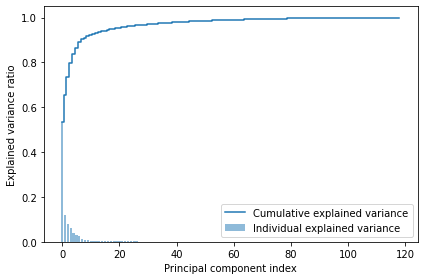

In [56]:
# Apply PCA algorithm
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(explained_variance)
# Create the visualization plot
plt.bar(range(0,len(explained_variance)), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [57]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
principalDf = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])
print(principalDf)

[0.53650325 0.11961931]
     principal component 1  principal component 2
0                -1.148648              -0.280787
1                 0.464469              -0.413949
2                -3.949292               0.476938
3                -0.980485               0.697671
4                -1.069713              -0.431223
..                     ...                    ...
479              -1.594228               0.711320
480               2.584350              -0.638979
481               0.515635               0.094432
482               0.595222               2.671508
483              -0.718188              -2.973767

[484 rows x 2 columns]


In [58]:
target = target.reset_index(drop = True)
finalDf = pd.concat([principalDf, target], axis = 1)

<Figure size 144x432 with 0 Axes>

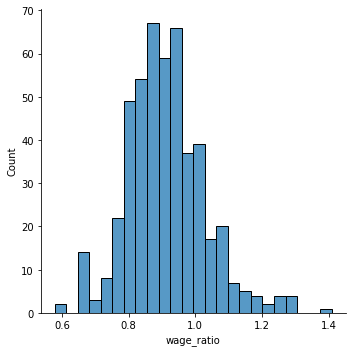

In [59]:
# check target range
fig = plt.figure(figsize = (2,6))
sns.displot(target)

Try binning wage_ratio to get 3 categories.

In [60]:
max_wr = max(target)
min_wr = min(target)
low_wr = np.percentile(target, 33)
med_wr = np.percentile(target, 66)
print('max:', max(target))
print('min:', min(target))
print('low:', np.percentile(target, 33))
print('med:', np.percentile(target, 66))
# group wage_ratio into 3 categories
target_gr_low = target[(target>=min_wr) & (target<low_wr)].index.tolist()
print(target_gr_low)
target_gr_med = target[(target>=low_wr) & (target<med_wr)].index.tolist()
print(target_gr_med)
target_gr_high = target[(target>=med_wr) & (target<=max_wr)].index.tolist()
print(target_gr_high)

max: 1.4096690360222364
min: 0.5784313725490196
low: 0.8571428571428571
med: 0.9459120175810618
[2, 14, 18, 21, 26, 29, 31, 32, 33, 38, 39, 40, 43, 46, 47, 49, 50, 54, 60, 61, 63, 68, 69, 79, 82, 84, 87, 88, 94, 98, 99, 100, 103, 106, 107, 114, 115, 118, 124, 125, 126, 127, 130, 133, 135, 138, 143, 147, 152, 153, 154, 156, 162, 165, 167, 168, 171, 172, 174, 180, 181, 182, 184, 188, 190, 191, 192, 194, 195, 198, 203, 204, 205, 209, 212, 213, 223, 236, 238, 241, 242, 243, 252, 253, 254, 259, 260, 261, 262, 267, 269, 272, 276, 277, 281, 287, 288, 289, 301, 307, 308, 312, 314, 315, 316, 325, 330, 331, 341, 345, 347, 351, 356, 357, 360, 363, 366, 369, 370, 378, 380, 382, 383, 384, 389, 390, 391, 392, 395, 396, 399, 406, 409, 413, 415, 419, 422, 424, 428, 431, 433, 436, 439, 442, 445, 448, 450, 454, 455, 459, 463, 464, 465, 466, 467]
[1, 5, 6, 13, 20, 25, 27, 28, 34, 36, 42, 48, 51, 55, 57, 59, 62, 64, 65, 67, 71, 72, 75, 76, 77, 83, 93, 95, 101, 102, 104, 108, 109, 113, 120, 122, 128, 129, 

In [61]:
target_cat = pd.DataFrame(np.zeros((len(target),1)))
for i in target_gr_low:
  target_cat.loc[i] = 'low'
for i in target_gr_med:
  target_cat.loc[i] = 'med'
for i in target_gr_high:
  target_cat.loc[i] = 'high'
print(target_cat)

        0
0    high
1     med
2     low
3    high
4    high
..    ...
479  high
480   med
481  high
482  high
483  high

[484 rows x 1 columns]


In [62]:
target_cat = target_cat.reset_index(drop = True)
target_cat.columns = ['target']
finalDf = pd.concat([principalDf, target_cat], axis = 1)
print(finalDf)

     principal component 1  principal component 2 target
0                -1.148648              -0.280787   high
1                 0.464469              -0.413949    med
2                -3.949292               0.476938    low
3                -0.980485               0.697671   high
4                -1.069713              -0.431223   high
..                     ...                    ...    ...
479              -1.594228               0.711320   high
480               2.584350              -0.638979    med
481               0.515635               0.094432   high
482               0.595222               2.671508   high
483              -0.718188              -2.973767   high

[484 rows x 3 columns]


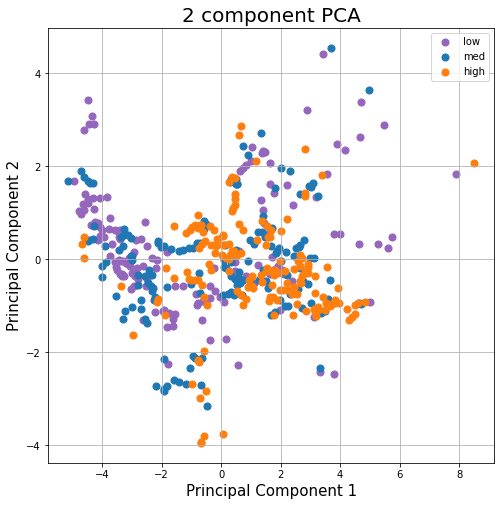

In [63]:
# Visualize 2D Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['low', 'med', 'high']
colors = ['tab:purple', 'tab:blue', 'tab:orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Models

## Multiple Linear Regression

### Create a Dataset of the mean values for each variable for the years 2010 to 2019 

In [64]:
# Filter for just the years 2010 to 2019
paygap_10s = paygap.loc[(paygap['year']>=2010) & (paygap['year'] <=2019)]
paygap_10s.drop('year', axis = 1, inplace=True)
#Create a grouped dataframe with average values for the time period
paygap_avg = paygap_10s.groupby(['region','country']).mean()
paygap_avg

se_m       se_f       pr_f        mys  \
region country                                                         
AS     Jordan             83.865644  77.437610  15.384615  10.335806   
       Lebanon            55.561827  54.313748   4.687500   8.718636   
EAP    Brunei Darussalam  70.077000  68.586000   4.545455   9.035000   
       Cambodia           24.524000  11.516000  18.478261   4.300000   
       Indonesia          54.025835  46.230062  18.606366   8.214185   
...                             ...        ...        ...        ...   
SSA    South Africa       87.666222  68.897713  45.333333  11.373160   
       Togo               36.421549  10.777225  15.425315   4.305697   
       Uganda             35.693000  26.229000  34.636267   5.372421   
       Zambia             53.506652  42.437628  17.964072   6.994631   
       Zimbabwe           66.405708  52.478859  35.142857   8.112470   

                                 mmr     lfpr_m     lfpr_f         le  \
region country                                                          
AS     Jordan              46.000000  63.263333  15.311000  75.773367   
       Lebanon             29.000000  66.635000  21.885000  79.235900   
EAP    Brunei Darussalam   30.000000  70.430000  56.285500  74.750400   
       Cambodia           215.000000  88.071000  78.357000  68.914900   
       Indonesia          177.000000  82.004000  52.944500  70.227000   
...                              ...        ...        ...        ...   
SSA    South Africa       119.000000  62.433000  48.453000  66.175000   
       Togo               405.333333  60.973333  55.542333  59.158267   
       Uganda             393.500000  74.245000  66.013500  60.465800   
       Zambia             213.000000  78.944000  69.737000  62.231150   
       Zimbabwe           494.000000  89.522000  80.314000  58.846000   

                                 gnipc        eys         abr  wage_ratio  
region country                                                             
AS     Jordan              9997.932563  10.373410   27.277667    1.079988  
       Lebanon            14377.648770  11.285870   20.896000    1.409669  
EAP    Brunei Darussalam  64477.882065  14.670990   11.146500    1.002919  
       Cambodia            2869.323018  10.940413   52.850000    0.822534  
       Indonesia          11021.337500  13.639932   35.439500    0.874289  
...                                ...        ...         ...         ...  
SSA    South Africa       13366.474640  13.643710   64.982000    0.904762  
       Togo                1924.468218  12.416783   83.142667    0.679970  
       Uganda              1990.851345  10.731886  121.994500    0.694158  
       Zambia              3374.324437  10.928168  126.582000    0.869144  
       Zimbabwe            3644.856047  11.478596  105.952000    0.857143  

[97 rows x 12 columns]

In [65]:
# Reset the index to add the Region back to every row
paygap_avg.reset_index(inplace = True)
paygap_avg

,region,country,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,wage_ratio
0,AS,Jordan,83.865644,77.437610,15.384615,10.335806,46.000000,63.263333,15.311000,75.773367,9997.932563,10.373410,27.277667,1.079988
1,AS,Lebanon,55.561827,54.313748,4.687500,8.718636,29.000000,66.635000,21.885000,79.235900,14377.648770,11.285870,20.896000,1.409669
2,EAP,Brunei Darussalam,70.077000,68.586000,4.545455,9.035000,30.000000,70.430000,56.285500,74.750400,64477.882065,14.670990,11.146500,1.002919
3,EAP,Cambodia,24.524000,11.516000,18.478261,4.300000,215.000000,88.071000,78.357000,68.914900,2869.323018,10.940413,52.850000,0.822534
4,EAP,Indonesia,54.025835,46.230062,18.606366,8.214185,177.000000,82.004000,52.944500,70.227000,11021.337500,13.639932,35.439500,0.874289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,SSA,South Africa,87.666222,68.897713,45.333333,11.373160,119.000000,62.433000,48.453000,66.175000,13366.474640,13.643710,64.982000,0.904762
93,SSA,Togo,36.421549,10.777225,15.425315,4.305697,405.333333,60.973333,55.542333,59.158267,1924.468218,12.416783,83.142667,0.679970
94,SSA,Uganda,35.693000,26.229000,34.636267,5.372421,393.500000,74.245000,66.013500,60.465800,1990.851345,10.731886,121.994500,0.694158
95,SSA,Zambia,53.506652,42.437628,17.964072,6.994631,213.000000,78.944000,69.737000,62.231150,3374.324437,10.928168,126.582000,0.869144


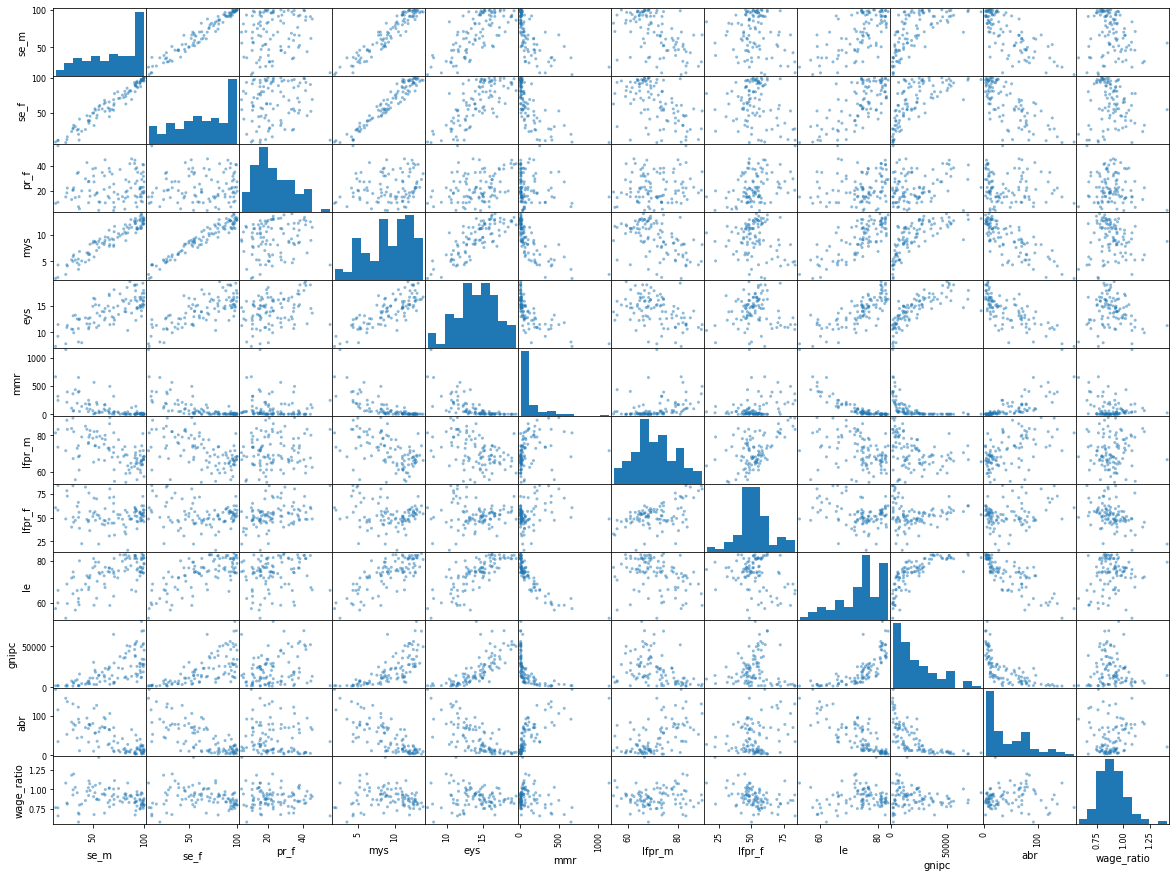

In [66]:
# Plot a scatter matrix for the all the numerical variables
scatter_matrix(paygap_avg[vars], figsize=(20,15))
plt.show()

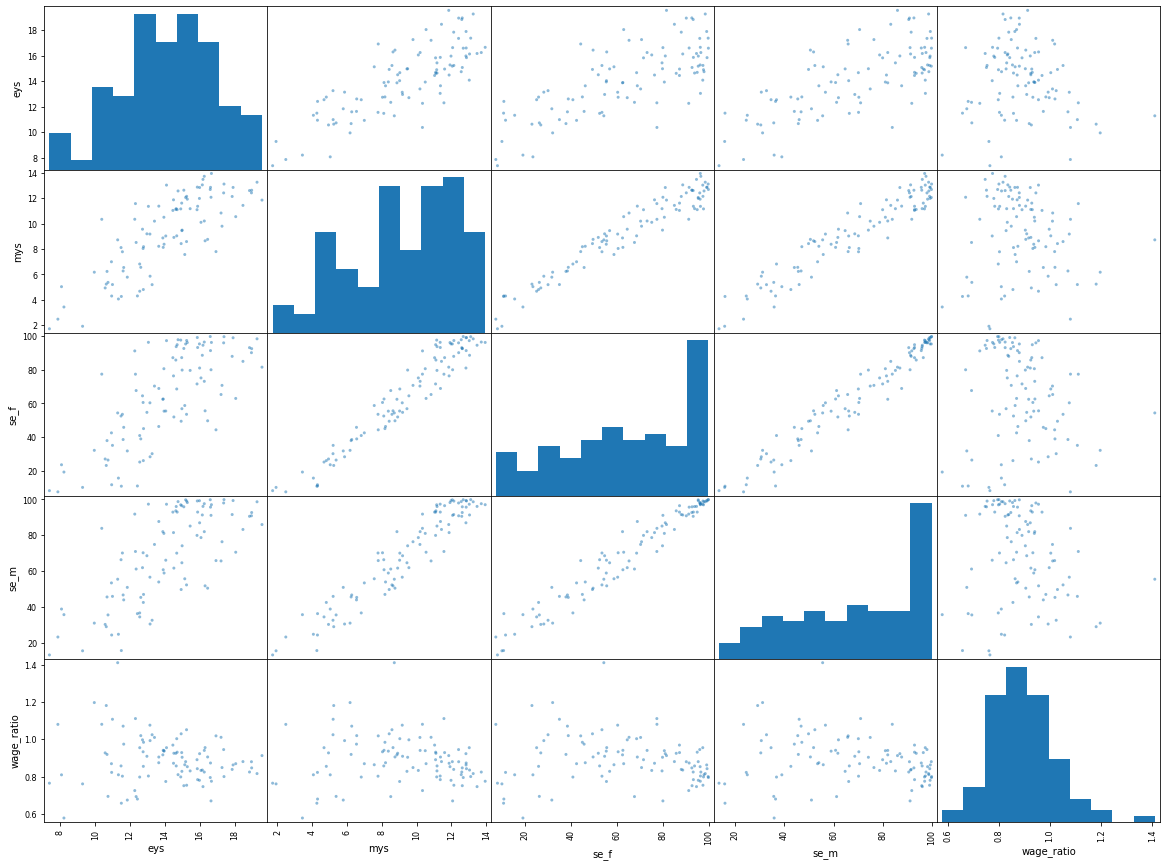

In [70]:
# Plot a scatter matrix for just the education variables
scatter_matrix(paygap_avg[education], figsize=(20,15))
plt.show()

Text(0.5, 1.0, '2010-2019 Average Values')

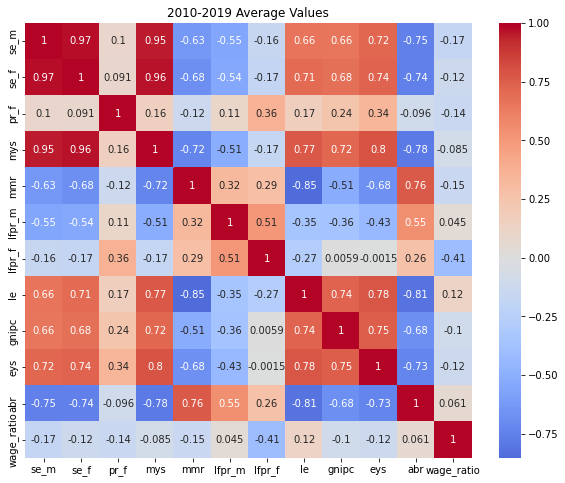

In [73]:
# Plot a correlation matrix heatmap for paygap_avg
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(data = paygap_avg.corr(), center = 0, annot = True, fmt='.2g', cmap = 'coolwarm')
plt.title("2010-2019 Average Values")

### Produce a stratified sample of the paygap_avg dataset

In [74]:
# How is the wage_ratio distributed in the dataset
print(paygap_avg['wage_ratio'].describe()) 

count    97.000000
mean      0.890024
std       0.127272
min       0.578431
25%       0.809808
50%       0.874289
75%       0.954762
max       1.409669
Name: wage_ratio, dtype: float64


In [75]:
# Create a new variable that bins the wage_ratio with equal observations in each bin
paygap_avg['wage_cat'] = pd.qcut(paygap_avg['wage_ratio'], 
                                q=5,
                                labels = [1,2,3,4,5])
# show the relative frequencies of the unique values of the new variable
print(paygap_avg['wage_cat'].value_counts(normalize = True).sort_index()) 

1    0.206186
2    0.195876
3    0.195876
4    0.195876
5    0.206186
Name: wage_cat, dtype: float64


In [76]:
from pandas.core.common import random_state
from sklearn.model_selection import StratifiedShuffleSplit

strat = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)    # Create a StratifiedShuffleSplit object

# Split the dataset based on the column 'wage_cat'
for train_index, test_index in strat.split(paygap_avg, paygap_avg['wage_cat']):
  strat_train_set = paygap_avg.loc[train_index]
  strat_test_set = paygap_avg.loc[test_index]


In [77]:
# Confirm the distribution of observations in the binned variable
print(strat_train_set['wage_cat'].value_counts(normalize = True).sort_index())
print(strat_test_set['wage_cat'].value_counts(normalize = True).sort_index())

1    0.207792
2    0.194805
3    0.194805
4    0.194805
5    0.207792
Name: wage_cat, dtype: float64
1    0.2
2    0.2
3    0.2
4    0.2
5    0.2
Name: wage_cat, dtype: float64


In [78]:
# Drop the wage_cat variable
strat_train_set.drop('wage_cat', axis=1, inplace=True)
strat_test_set.drop('wage_cat', axis=1, inplace=True)

In [79]:
# Create a deep copy and rename
train_avg = strat_train_set.copy()
test_avg = strat_test_set

In [80]:
# Separate the dependent (Y) and independent (X) variables
train_avg_X = train_avg.drop('wage_ratio', axis = 1)
train_avg_Y = train_avg['wage_ratio'].copy()

test_avg_X = test_avg.drop('wage_ratio', axis = 1)
test_avg_Y = test_avg['wage_ratio'].copy()

### Encode the region column

In [81]:
# Encode the categorical variables
train_avg_X = pd.get_dummies(train_avg_X, columns = ['region'])
train_avg_X.drop('country', axis = 1, inplace = True)
train_avg_X

,se_m,se_f,pr_f,mys,mmr,lfpr_m,lfpr_f,le,gnipc,eys,abr,region_AS,region_EAP,region_ECA,region_LAC,region_No_Region,region_SA,region_SSA
35,44.060000,45.728000,42.391304,6.544000,103.000000,83.162000,47.948000,72.812100,5257.845956,11.631528,94.226000,0,0,0,1,0,0,0
18,68.618755,54.655051,33.333333,9.193347,8.000000,67.974000,44.009000,75.934700,14359.469580,12.961490,18.327000,0,0,1,0,0,0,0
6,74.897310,70.328729,13.672481,10.192407,29.625000,77.461750,49.285250,75.171787,23607.491680,13.395111,12.186250,0,1,0,0,0,0,0
26,78.717390,75.174675,15.506329,10.099880,15.250000,72.124250,48.170500,79.636275,22684.424898,16.061885,42.139750,0,0,0,1,0,0,0
71,90.839625,90.226154,44.297994,12.419297,4.200000,67.543400,60.797400,82.343320,51903.112890,18.954104,4.610200,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,31.151920,32.020719,22.482639,6.174857,67.555556,81.868000,44.963000,72.278556,4963.701379,9.946177,79.316222,0,0,0,1,0,0,0
13,92.903100,94.975638,27.857143,11.096983,15.000000,67.247000,51.189000,79.183800,13302.705960,14.695620,15.580000,0,0,1,0,0,0,0
21,96.948310,97.721037,12.019231,11.155778,20.000000,63.756000,50.118000,74.312100,11649.481050,14.900928,26.365000,0,0,1,0,0,0,0
76,42.643201,25.895426,29.579832,4.808860,186.000000,84.835000,82.243000,68.909900,3601.108877,12.756130,70.165000,0,0,0,0,0,1,0


In [83]:
train_avg_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 35 to 23
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   se_m              77 non-null     float64
 1   se_f              77 non-null     float64
 2   pr_f              77 non-null     float64
 3   mys               77 non-null     float64
 4   mmr               77 non-null     float64
 5   lfpr_m            77 non-null     float64
 6   lfpr_f            77 non-null     float64
 7   le                77 non-null     float64
 8   gnipc             77 non-null     float64
 9   eys               77 non-null     float64
 10  abr               77 non-null     float64
 11  region_AS         77 non-null     uint8  
 12  region_EAP        77 non-null     uint8  
 13  region_ECA        77 non-null     uint8  
 14  region_LAC        77 non-null     uint8  
 15  region_No_Region  77 non-null     uint8  
 16  region_SA         77 non-null     uint8  
 17

### Train the Model

In [82]:
from pyparsing.helpers import line
from sklearn.linear_model import LinearRegression

# Call the constructor
lin_reg = LinearRegression(fit_intercept= True)
lin_reg = LinearRegression()

# Call .fit() on the training data
lin_reg.fit(train_avg_X, train_avg_Y)

# Make predictions on the training data
lin_reg.predict(train_avg_X)

array([1.00536135, 0.95322917, 0.94845634, 0.88187542, 0.84548581,
       0.83841249, 0.83203247, 1.07998755, 0.87827627, 0.57037547,
       0.87244829, 1.00991184, 0.80165657, 0.96608994, 0.92941828,
       0.83061881, 0.93539615, 1.00754955, 0.79229897, 0.83301381,
       0.97846344, 0.88626887, 0.92351775, 0.79971983, 0.80933896,
       0.84238526, 0.88989913, 0.87868686, 0.9811238 , 0.94214351,
       1.00885296, 0.86514516, 0.85390254, 0.83233826, 1.01321901,
       0.86431024, 0.71309624, 0.88032212, 0.96495928, 0.8297911 ,
       1.0394991 , 0.82476697, 0.87527919, 0.80073581, 0.99651019,
       0.91663429, 0.98634973, 0.87578215, 0.91939908, 0.93567622,
       0.83360844, 0.83900211, 0.79928703, 0.77250507, 0.85018765,
       0.86926715, 0.83906657, 1.03843464, 0.82244174, 0.82741867,
       1.02247516, 0.91334746, 0.80801919, 0.82560059, 0.89398097,
       1.00318361, 0.90424358, 0.82507113, 0.77104502, 0.87848335,
       0.79617827, 0.97781687, 1.04014663, 0.8368941 , 0.85603